<a href="https://colab.research.google.com/github/Sharame/ModuliDiMachineLearningProgettiUniversitari/blob/main/data_generator/SyntetichGymDatatset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Gym Logs Generator (Set-level)
Generatore di dataset sintetico per log di allenamento **per serie** (set-level) con:
- finestra temporale per utente variabile (end_date tra oggi e +2 anni, durata 2 settimane → 2 anni)
- simulazione a stati (fitness/fatigue/skill/resilience)
- eventi (skip, injury)
- output canonico: `workout_sets.csv`
- output derivati: `workoutlogs.csv` (per esercizio), `sessions.csv` (per sessione), `banisterdaily.csv`

Obiettivo: produrre dati realistici e poi derivare viste aggregate per i moduli ML.


**CELL 1 — (Python) Setup**

In [536]:
!pip -q install pandas numpy

import os, json, math
from dataclasses import dataclass
from pathlib import Path
from datetime import date, timedelta, datetime
import numpy as np
import pandas as pd


**CELL 2 — (Python) Config**

In [537]:
@dataclass
class CFG:
    seed: int = 27
    outdir: str = "data_synth_setlevel"

    n_users: int = 300

    # Per-user date ranges
    today: date = date.today()
    end_date_max_days_ahead: int = 730     # oggi -> +2 anni
    min_duration_days: int = 14           # 2 settimane
    max_duration_days: int = 730          # 2 anni

    # Training schedule
    weekly_freq_mu: float = 3.5
    weekly_freq_sd: float = 1.0
    weekly_freq_min: int = 1
    weekly_freq_max: int = 6
    weekday_jitter_probs = (0.15, 0.70, 0.15)  # -1,0,+1

    # Quantization / realism
    load_step: float = 0.25
    rpe_step: float = 0.5

    # Skip model (baseline per livello)
    skip_p0_by_level: dict = None  # lo definiamo sotto
    # quanto la fatica aumenta lo skip (modulatore leggero)
    skip_fatigue_weight: float = 0.25
    skip_fatigue_cap: float = 1.2
    skip_noise_sd: float = 0.10

    # cap e rumore (tengono stabile il sistema)
    skip_fatigue_cap = 1.2
    skip_noise_sd = 0.10

    skip_exp_fatigue_scale = 0.85   # quanto l’esperienza "spegne" l’effetto fatica (0.0=nessun effetto)

    skip_exp_weight: float = 1.2

    injury_lambda: float = 0.002   # scala probabilità injury
    injury_days_min: int = 7
    injury_days_max: int = 28

    # Missingness (solo su osservazioni)
    p_missing_rpe: float = 0.02
    p_missing_load: float = 0.01
    p_missing_feedback: float = 0.02

    # Banister-like params
    tauF_mean: float = 45.0
    tauF_sd: float = 8.0
    tauD_mean: float = 7.0
    tauD_sd: float = 2.0
    betaF: float = 0.010
    betaD: float = 0.015

    # === PROGRESSIVE OVERLOAD (dose-driven) ===
    overload_base_rate: dict = None      # tasso crescita per livello
    overload_I0: float = 1800.0          # impulse normalizzazione (mediana attesa)
    overload_quality_fatigue: float = 0.6  # quanto la fatica riduce quality
    # Transfer weights
    transfer_same_muscle: float = 0.35   # stesso targetmusclegroup
    transfer_same_split: float = 0.12    # stesso splitcat


# Default per skip_p0_by_level
if not hasattr(CFG, '__dataclass_fields__') or 'skip_p0_by_level' not in CFG.__dataclass_fields__:
    CFG.skip_p0_by_level = {
      "Beginner": 0.10,      # era 0.13 → abbassato per target ~12-13%
      "Intermediate": 0.065,  # era 0.08 → abbassato per target ~8%
      "Advanced": 0.05,       # già perfetto, lasciato invariato
}

cfg = CFG()

cfg.skip_p0_by_level = {
    "Beginner": 0.10,
    "Intermediate": 0.065,
    "Advanced": 0.05,
}

cfg.overload_base_rate = {
    "Beginner": 0.0500,      # ← DA 0.0180 A 0.0300 (x2.7)
    "Intermediate": 0.0050,  # OK
    "Advanced": 0.0040,      # OK
}

rng = np.random.default_rng(cfg.seed)

OUTDIR = Path(cfg.outdir)
OUTDIR.mkdir(parents=True, exist_ok=True)

cfg.today


datetime.date(2026, 1, 31)

**CELL 3 — (Python) Utils**

In [538]:
def sigmoid(z: float) -> float:
    return 1.0 / (1.0 + math.exp(-z))

def qload(x: float, step: float) -> float:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    return float(np.round(x / step) * step)

def qrpe(x: float, step: float) -> float:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.nan
    x = float(np.clip(x, 1.0, 10.0))
    return float(np.round(x / step) * step)

def clamp_int(x, lo, hi):
    return int(np.clip(int(round(x)), lo, hi))

def sample_split(rng):
    return str(rng.choice(["PPL", "FullBody"], p=[0.7, 0.3]))

def exp_weights(L: int, tau: float) -> np.ndarray:
    idx = np.arange(L, dtype=float)
    return np.exp(-idx / float(tau))

def logit(p: float) -> float:
    """Inverse sigmoid: logit(p) = ln(p/(1-p))"""
    return math.log(p/(1-p))


In [539]:
# === VERIFICA CONFIG ===
print("Controllo configurazione skip:")
print(f"  cfg.skip_p0_by_level = {cfg.skip_p0_by_level}")
print(f"  cfg.skip_fatigue_weight = {cfg.skip_fatigue_weight}")

try:
    test_val = logit(0.10)
    print(f"logit(0.10) = {test_val:.3f}")
except NameError:
    print("ERRORE: logit() non è definita!")


Controllo configurazione skip:
  cfg.skip_p0_by_level = {'Beginner': 0.1, 'Intermediate': 0.065, 'Advanced': 0.05}
  cfg.skip_fatigue_weight = 0.25
logit(0.10) = -2.197


**CELL 4 — (Python) Load exercise catalog (fallback incluso)**

In [540]:
def load_exercises_catalog(path: str = "esercizi_catalogo80.csv") -> pd.DataFrame:
    p = Path(path)
    if p.exists():
        df = pd.read_csv(p)

        rename_map = {
            "idEsercizio": "exerciseid",
            "nome": "name",
            "gruppoMuscolare": "targetmusclegroup",
            "livelloEsercizio": "difficultylevel",
            "Mechanics": "mechanics"
        }
        for k, v in rename_map.items():
            if k in df.columns and v not in df.columns:
                df = df.rename(columns={k: v})
        if "splitcat" not in df.columns:
            df["splitcat"] = "other"
        keep = ["exerciseid","name","targetmusclegroup","mechanics","difficultylevel",
                "equipment","bodyregion","splitcat"]
        for c in keep:
            if c not in df.columns:
                df[c] = None
        df = df[keep].copy()
        df["exerciseid"] = df["exerciseid"].astype(int)
        df["splitcat"] = df["splitcat"].astype(str).str.lower()
        return df.sort_values("exerciseid").reset_index(drop=True)

    # Fallback minimale (estendibile)
    rows = [
        (1,"Bench Press","Chest","Compound","Intermediate","Barbell","Upper Body","push"),
        (2,"Barbell Row","Back","Compound","Intermediate","Barbell","Upper Body","pull"),
        (3,"Squat","Quadriceps","Compound","Advanced","Barbell","Lower Body","legs"),
        (4,"Cable Fly","Chest","Isolation","Beginner","Cable","Upper Body","push"),
        (5,"Lat Pulldown","Back","Compound","Beginner","Machine","Upper Body","pull"),
        (6,"Leg Press","Quadriceps","Compound","Intermediate","Machine","Lower Body","legs"),
        (7,"Plank","Abdominals","Compound","Beginner","Bodyweight","Core","core"),
        (8,"Lateral Raise","Shoulders","Isolation","Beginner","Dumbbell","Upper Body","push"),
        (9,"Romanian Deadlift","Hamstrings","Compound","Advanced","Barbell","Lower Body","legs"),
        (10,"Incline DB Press","Chest","Compound","Intermediate","Dumbbell","Upper Body","push"),
        (11,"Seated Cable Row","Back","Compound","Beginner","Cable","Upper Body","pull"),
        (12,"Leg Curl","Hamstrings","Isolation","Beginner","Machine","Lower Body","legs"),
    ]
    return pd.DataFrame(rows, columns=[
        "exerciseid","name","targetmusclegroup","mechanics","difficultylevel",
        "equipment","bodyregion","splitcat"
    ])

df_ex = load_exercises_catalog()
df_ex.head()


,exerciseid,name,targetmusclegroup,mechanics,difficultylevel,equipment,bodyregion,splitcat
0,1,Bench Press,Chest,Compound,Intermediate,Barbell,Upper Body,push
1,2,Barbell Row,Back,Compound,Intermediate,Barbell,Upper Body,pull
2,3,Squat,Quadriceps,Compound,Advanced,Barbell,Lower Body,legs
3,4,Cable Fly,Chest,Isolation,Beginner,Cable,Upper Body,push
4,5,Lat Pulldown,Back,Compound,Beginner,Machine,Upper Body,pull


**CELL 5 — (Python) Sample user latents + per-user date windows**

In [541]:
LEVELS = ["Beginner", "Intermediate", "Advanced"]

def sample_user_window(cfg: CFG, rng) -> tuple[date, date]:
    end_date = cfg.today + timedelta(days=int(rng.integers(0, cfg.end_date_max_days_ahead + 1)))
    dur = int(rng.integers(cfg.min_duration_days, cfg.max_duration_days + 1))
    start_date = end_date - timedelta(days=dur)
    return start_date, end_date

def sample_user_latents(cfg: CFG, rng):
    # experience_latent in [0,1], 0=novice-ish, 1=advanced-ish
    exp_lat = float(np.clip(rng.beta(2.0, 2.0), 0.0, 1.0))

    # Parametri continui
    # adattamento: più alto per exp_lat bassa
    alpha = float(np.clip(rng.normal(0.05 - 0.03*exp_lat, 0.01), 0.005, 0.08))
    # detraining: più alto per exp_lat bassa
    k_d = float(np.clip(rng.normal(0.020 - 0.012*exp_lat, 0.004), 0.002, 0.03))
    # noise: più alto per exp_lat bassa
    obs_noise = float(np.clip(rng.normal(0.25 - 0.18*exp_lat, 0.05), 0.03, 0.35))

    resilience = float(np.clip(rng.normal(1.0 + 0.6*exp_lat, 0.25), 0.4, 2.2))
    fatigue_sens = float(np.clip(rng.lognormal(mean=-0.2, sigma=0.35), 0.2, 2.0))

    return dict(
        experience_latent=exp_lat,
        alpha_adapt=alpha,
        k_detraining=k_d,
        obs_noise=obs_noise,
        resilience=resilience,
        fatigue_sens=fatigue_sens,
        rpe_report_bias=float(rng.normal(0.0, 0.35)),
    )

def latents_to_experience_label(exp_lat: float) -> str:
    # discretizzazione semplice
    # 3 classi: Beginner / Intermediate / Advanced
    if exp_lat < 0.40:
        return "Beginner"
    if exp_lat < 0.80:
        return "Intermediate"
    return "Advanced"

def generate_users(cfg: CFG, rng) -> pd.DataFrame:
    rows = []
    for uid in range(1, cfg.n_users + 1):
        start_u, end_u = sample_user_window(cfg, rng)
        weekly_freq = clamp_int(rng.normal(cfg.weekly_freq_mu, cfg.weekly_freq_sd),
                                cfg.weekly_freq_min, cfg.weekly_freq_max)
        split = sample_split(rng)

        lat = sample_user_latents(cfg, rng)
        exp_label = latents_to_experience_label(lat["experience_latent"])

        rows.append({
            "userid": uid,
            "weeklyfreqdeclared": weekly_freq,
            "splittype": split,
            "start_date": start_u.isoformat(),
            "end_date": end_u.isoformat(),

            # label target (non nei log)
            "experience_label": exp_label,

            # latenti
            "experience_latent": round(lat["experience_latent"], 4),
            "alpha_adapt": round(lat["alpha_adapt"], 5),
            "k_detraining": round(lat["k_detraining"], 5),
            "obs_noise": round(lat["obs_noise"], 4),
            "resilience": round(lat["resilience"], 4),
            "fatigue_sens": round(lat["fatigue_sens"], 4),
            "rpe_report_bias": round(lat["rpe_report_bias"], 4),
        })
    return pd.DataFrame(rows)

df_users = generate_users(cfg, rng)
df_users.head()


,userid,weeklyfreqdeclared,splittype,start_date,end_date,experience_label,experience_latent,alpha_adapt,k_detraining,obs_noise,resilience,fatigue_sens,rpe_report_bias
0,1,4,PPL,2024-09-05,2026-02-01,Beginner,0.2995,0.05222,0.01466,0.1321,1.0623,0.5385,-0.6439
1,2,4,PPL,2024-04-12,2026-02-05,Intermediate,0.4700,0.03279,0.01361,0.1870,0.9602,0.9363,0.3472
2,3,4,FullBody,2026-02-25,2026-05-29,Beginner,0.2713,0.04981,0.01256,0.2242,1.5184,0.6392,0.2331
3,4,3,FullBody,2025-01-20,2026-03-11,Intermediate,0.4448,0.05200,0.01132,0.2132,1.4421,0.8406,0.2141
4,5,4,PPL,2025-02-11,2026-06-03,Beginner,0.2797,0.03763,0.02190,0.2159,1.0132,0.6727,0.4974


**CELL 6 — (Python) Capabilities (cmax) + templates per split**

In [542]:
BASEMAP = {"Beginner": 50.0, "Intermediate": 80.0, "Advanced": 105.0}

def build_capabilities(df_users: pd.DataFrame, df_ex: pd.DataFrame, rng) -> dict:
    caps = {}
    for u in df_users.itertuples(index=False):
        uid = int(u.userid)
        exp_label = str(u.experience_label)
        exp_lat = float(u.experience_latent)

        # scala base da label (solo per cmax "medio"), ma con jitter continuo su exp_lat
        # Nota: non stiamo usando la label per governare dinamiche; è solo un prior sul massimo teorico.
        base_factor = BASEMAP.get(exp_label, 70.0) * (0.85 + 0.30*exp_lat)

        usermap = {}
        for ex in df_ex.itertuples(index=False):
            # difficoltà esercizio influenza cmax relativo
            diff = str(ex.difficultylevel)
            diff_mul = {"Beginner": 0.85, "Intermediate": 1.0, "Advanced": 1.12}.get(diff, 1.0)
            cmax = base_factor * diff_mul * float(rng.normal(1.0, 0.12))
            cmax = float(np.clip(cmax, 10.0, 200.0))
            usermap[int(ex.exerciseid)] = qload(cmax, cfg.load_step)
        caps[uid] = usermap
    return caps

PPL_ROT = ["Push", "Pull", "Legs"]
FB_ROT = ["FullBody-A", "FullBody-B", "FullBody-C"]

def choose_exercises_for_tag(df_ex: pd.DataFrame, tag: str, rng, n_min=3, n_max=6):
    if tag.startswith("FullBody"):
        pools = {
            "legs": df_ex[df_ex["splitcat"].isin(["legs"])],
            "push": df_ex[df_ex["splitcat"].isin(["push"])],
            "pull": df_ex[df_ex["splitcat"].isin(["pull"])],
            "core": df_ex[df_ex["splitcat"].isin(["core"])],
            "other": df_ex[~df_ex["splitcat"].isin(["legs","push","pull","core"])],
        }
        exids = []
        for k, n in [("legs",1),("push",1),("pull",1)]:
            if len(pools[k]) > 0:
                exids += rng.choice(pools[k]["exerciseid"].values, size=n, replace=False).tolist()
        if len(pools["core"]) and rng.random() < 0.6:
            exids += rng.choice(pools["core"]["exerciseid"].values, size=1, replace=False).tolist()
        while len(exids) < 4:
            pool = pools["other"] if len(pools["other"]) else df_ex
            exids += rng.choice(pool["exerciseid"].values, size=1, replace=False).tolist()
        # dedup mantenendo ordine
        seen = set()
        exids2 = []
        for x in exids:
            if x not in seen:
                seen.add(x)
                exids2.append(int(x))
        return exids2[:6]

    # PPL
    tag_l = tag.lower()
    pool = df_ex[df_ex["splitcat"] == tag_l]
    if len(pool) < 3:
        pool = df_ex.copy()
    n = int(rng.integers(n_min, n_max + 1))
    n = min(n, len(pool))
    return [int(x) for x in rng.choice(pool["exerciseid"].values, size=n, replace=False)]

def build_user_templates(df_users, df_ex, rng):
    templates = {}
    for u in df_users.itertuples(index=False):
        uid = int(u.userid)
        split = str(u.splittype)
        tags = PPL_ROT if split == "PPL" else FB_ROT
        templates[uid] = {tag: choose_exercises_for_tag(df_ex, tag, rng) for tag in tags}
    return templates

caps = build_capabilities(df_users, df_ex, rng)
templates = build_user_templates(df_users, df_ex, rng)

list(templates.items())[0]


(1, {'Push': [8, 1, 4, 10], 'Pull': [5, 2, 11], 'Legs': [6, 9, 12, 3]})

**CELL 7 — (Python) Plan prescription (per esercizio) + helpers intensità**

In [543]:
def prescribe_exercise(df_ex_row: dict, experience_label: str, rng):
    # Range reps/sets/rest/rir per esercizio (semplice e stabile)
    lvl = str(df_ex_row["difficultylevel"])

    # default base su difficoltà esercizio (non su esperienza!)
    if lvl == "Beginner":
        reps_mu, reps_sd = 12, 2
        sets_lo, sets_hi = 2, 4
        rest_lo, rest_hi = 60, 120
    elif lvl == "Intermediate":
        reps_mu, reps_sd = 8, 2
        sets_lo, sets_hi = 3, 5
        rest_lo, rest_hi = 90, 180
    else:  # Advanced/altro
        reps_mu, reps_sd = 6, 2
        sets_lo, sets_hi = 3, 6
        rest_lo, rest_hi = 120, 240

    # RIR target può dipendere dall'esperienza (scelta coaching), ma non entra come "flag di dinamica"
    # (serve per definire la prescrizione, che è osservabile nel plan)
    if experience_label in ["Beginner", "Novice"]:
        rir_mu = 2.5
    elif experience_label == "Intermediate":
        rir_mu = 2.0
    else:
        rir_mu = 1.5

    setsplanned = int(rng.integers(sets_lo, sets_hi + 1))
    repsmid = clamp_int(rng.normal(reps_mu, reps_sd), 3, 20)
    width = 2 if lvl != "Beginner" else 3
    repsmin = max(1, repsmid - width)
    repsmax = min(30, repsmid + width)

    restplannedsec = int(rng.integers(rest_lo, rest_hi + 1))
    rirtarget = clamp_int(rng.normal(rir_mu, 0.6), 0, 5)

    return setsplanned, repsmin, repsmax, restplannedsec, rirtarget

def intensity_from_reps_rir(reps_target: float, rir_target: float, rng):
    # euristica: più reps e più RIR => intensità minore
    base = 0.86 - 0.018*(reps_target - 5.0) - 0.03*rir_target
    base += float(rng.normal(0.0, 0.02))
    return float(np.clip(base, 0.35, 0.92))


**CELL 8 — (Python) Scheduler per utente + simulazione set-level (core)**

In [544]:
def schedule_sessions_for_user(start_u: date, end_u: date, weekly_freq: int, rng):
    # giorni target della settimana
    basedays = sorted(rng.choice(np.arange(7), size=weekly_freq, replace=False).tolist())
    dates = []
    d0 = start_u
    n_days = (end_u - start_u).days + 1
    for i in range(n_days):
        day = d0 + timedelta(days=i)
        if day.weekday() in basedays:
            # jitter -1/0/+1
            jitter = int(rng.choice([-1,0,1], p=cfg.weekday_jitter_probs))
            day2 = day + timedelta(days=jitter)
            if start_u <= day2 <= end_u:
                dates.append(day2)
    dates = sorted(list(set(dates)))
    return dates

def simulate_user(cfg: CFG, user_row: dict, df_ex: pd.DataFrame, caps_u: dict, templates_u: dict, rng):
    uid = int(user_row["userid"])
    start_u = date.fromisoformat(user_row["start_date"])
    end_u = date.fromisoformat(user_row["end_date"])
    weekly_freq = int(user_row["weeklyfreqdeclared"])
    experience_label = str(user_row["experience_label"])

    # latenti (stato + parametri)
    exp_lat = float(user_row["experience_latent"])
    alpha = float(user_row["alpha_adapt"])
    k_d = float(user_row["k_detraining"])
    obs_noise = float(user_row["obs_noise"])
    resilience = float(user_row["resilience"])
    fatigue_sens = float(user_row["fatigue_sens"])
    rpe_bias = float(user_row["rpe_report_bias"])

    # Banister params per utente
    tauF = float(max(7.0, rng.normal(cfg.tauF_mean, cfg.tauF_sd)))
    tauD = float(max(2.0, rng.normal(cfg.tauD_mean, cfg.tauD_sd)))

    # stato dinamico (scalari)
    fitness = float(rng.normal(0.0, 1.0))
    fatigue = float(max(0.0, rng.normal(0.5, 0.3)))
    skill = float(np.clip(rng.normal(0.2 + 0.6*exp_lat, 0.15), 0.0, 2.0))

    # injury state
    injury_until = None

    # schedule “candidato”
    session_dates = schedule_sessions_for_user(start_u, end_u, weekly_freq, rng)

    workouts_rows = []
    plan_rows = []
    sets_rows = []
    impulse_rows = []

    wid = 1  # per-user counter, poi lo rendiamo globale fuori
    set_id_counter = 1

    # rotazione tag per split
    tags = PPL_ROT if str(user_row["splittype"]) == "PPL" else FB_ROT
    tag_i = int(rng.integers(0, len(tags)))

    last_train_date = None

    # --- PROGRESSIVE OVERLOAD STATE ---
    # Copia dinamica delle capacità (evolveranno nel tempo)
    current_caps = {eid: float(val) for eid, val in caps_u.items()}

    # Tasso crescita personale
    base_growth = cfg.overload_base_rate.get(experience_label, 0.001)
    growth_rate = float(np.clip(rng.normal(base_growth, 0.0002), 1e-5, 0.005))


    for d in session_dates:
        # detraining: se gap
        if last_train_date is not None:
            gap = (d - last_train_date).days
            if gap > 1:
                fitness *= math.exp(-k_d * gap)

                    # Detraining anche su capacità se gap molto lungo (>7 giorni)
                    # if gap > 7:
                    #     decay = math.exp(-k_d * (gap - 7) * 0.3)
                    #     for eid in current_caps:
                    #         current_caps[eid] *= decay


        # decay fatica giornaliero
        fatigue *= math.exp(-1.0/7.0)


        # se infortunio
        in_injury = (injury_until is not None and d <= injury_until)



        # skip probability
        # --- SKIP MODEL (baseline per livello + fatica leggera) ---
        p0 = float(cfg.skip_p0_by_level.get(experience_label, 0.10))
        bias = logit(p0)

        fat_term = float(np.log1p(max(0.0, float(fatigue))))
        fat_term = min(fat_term, float(cfg.skip_fatigue_cap))

        z = bias + float(cfg.skip_fatigue_weight) * fat_term + float(rng.normal(0.0, cfg.skip_noise_sd))
        p_skip = sigmoid(z)

        status = "done"
        if rng.random() < p_skip:
            status = "skipped"
        # ----------------------------------------



        # assegna tag sessione
        tag = tags[tag_i % len(tags)]
        tag_i += 1

        week_index_user = (d - start_u).days // 7 + 1

        workouts_rows.append({
            "userid": uid,
            "date": d.isoformat(),
            "weekindex_user": int(week_index_user),
            "sessiontag": tag,
            "workoutstatus": status,
            "z_skip": float(z),
            "p_skip": float(p_skip),
            "fatigue_term": float(fat_term),
            "experience_label": experience_label,
        })

        if status == "skipped":
            impulse_rows.append({"userid": uid, "date": d.isoformat(), "impulse": 0.0})
            continue

        # plan per esercizio (per questa sessione)
        exids = templates_u.get(tag, [])
        if len(exids) == 0:
            exids = templates_u[list(templates_u.keys())[0]]

        # fatica intra-sessione (scalare semplice)
        fatigue_session = float(fatigue)

        day_impulse = 0.0
        day_total_sets = 0

        for exid in exids:
            exrow = df_ex[df_ex["exerciseid"] == exid].iloc[0].to_dict()
            setsplanned, repsmin, repsmax, restplannedsec, rirtarget = prescribe_exercise(exrow, experience_label, rng)

            # eventuale riduzione volume in injury
            if in_injury:
                setsplanned = max(1, int(round(setsplanned * 0.6)))

            plan_rows.append({
                "userid": uid,
                "date": d.isoformat(),
                "sessiontag": tag,
                "exerciseid": int(exid),
                "setsplanned": int(setsplanned),
                "repsmin": int(repsmin),
                "repsmax": int(repsmax),
                "restplannedsec": int(restplannedsec),
                "rirtarget": int(rirtarget),
            })

            # Usa capacità CORRENTE (dinamica)
            cmax = current_caps.get(int(exid), 50.0)

            # intended baseline load (per esercizio) dalla prima serie
            reps_target0 = int(rng.integers(repsmin, repsmax + 1))
            inten0 = intensity_from_reps_rir(reps_target0, rirtarget, rng)
            intended_load = qload(inten0 * cmax, cfg.load_step)

            # “esecuzione”: setdone ~ setsplanned con rumore/aderenza implicita
            setsdone = int(np.clip(round(rng.normal(setsplanned, 0.5)), 1, 10))

            for s in range(1, setsdone + 1):
                day_total_sets += 1

                reps_target = int(rng.integers(repsmin, repsmax + 1))
                inten = intensity_from_reps_rir(reps_target, rirtarget, rng)

                fatigue_factor = float(np.clip(0.03 * fatigue_session * fatigue_sens, 0.0, 0.20))

                # Riduzione fatica per Beginner (per permettere newbie gains)
                if experience_label == "Beginner":
                    fatigue_factor *= 0.2  # riduce dell'80% (era 70%)



                load_done = float(inten * cmax * (1.0 - fatigue_factor))
                load_done *= float(rng.normal(1.0, 0.03 + obs_noise*0.08))
                load_done = qload(float(np.clip(load_done, 2.5, cmax)), cfg.load_step)

                # reps calano se fatica sale
                reps_done = int(np.clip(round(rng.normal(reps_target * (1.0 - 0.20*fatigue_factor), 0.6 + obs_noise*1.5)),
                                        1, 30))

                # RPE cresce con intensità e fatica e gap reps
                rep_gap = (reps_target - reps_done) / max(1.0, reps_target)
                rpe_true = 4.0 + 5.5*inten + 1.8*rep_gap + 1.2*fatigue_factor
                rpe_obs = float(rng.normal(rpe_true + rpe_bias, 0.35 + obs_noise))
                rpe_done = qrpe(rpe_obs, cfg.rpe_step)

                # feedback raro
                feedback = None
                if rng.random() < 0.03:
                    feedback = str(rng.choice([
                        "Tecnica ok", "Fatica alta", "Allenamento solido", "Recuperi corti", "Non ero in giornata"
                    ]))

                # missingness (solo osservazioni)
                if rng.random() < cfg.p_missing_rpe:
                    rpe_done = np.nan
                if rng.random() < cfg.p_missing_load:
                    load_done = np.nan
                if rng.random() < cfg.p_missing_feedback:
                    feedback = None

                sets_rows.append({
                    "set_id": f"U{uid:04d}_S{set_id_counter:07d}",
                    "userid": uid,
                    "date": d.isoformat(),
                    "weekindex_user": int(week_index_user),
                    "sessiontag": tag,
                    "exerciseid": int(exid),

                    "set_index": int(s),

                    "reps_target": int(reps_target),
                    "reps_done": int(reps_done),
                    "load_intended_kg": float(intended_load),
                    "load_done_kg": load_done,
                    "rpe_done": rpe_done,

                    "restplannedsec": int(restplannedsec),
                    "rirtarget": int(rirtarget),
                    "feedback": feedback,
                })
                set_id_counter += 1

                # impulso giornaliero (Banister input)
                ld = 0.0 if (isinstance(load_done, float) and np.isnan(load_done)) else float(load_done)
                rd = 0.0 if (isinstance(rpe_done, float) and np.isnan(rpe_done)) else float(rpe_done)
                day_impulse += ld * float(reps_done) * (rd / 10.0)

                # aggiorna fatica intra-sessione
                fatigue_session += 0.08 * inten + 0.02 * (ld / max(20.0, cmax))

            # aggiorna fitness/fatica/skill post-esercizio (molto semplice)
            # carico “effettivo” = intended * volume relativo
            vol_proxy = setsdone * reps_target0 * float(intended_load)
            fitness += alpha * math.log1p(vol_proxy / 1000.0)
            skill += 0.002 * math.log1p(1.0 + exp_lat)  # crescita lenta


        # --- APPLICA PROGRESSIVE OVERLOAD (dose-driven + transfer) ---
        if status == "done" and day_impulse > 5.0 and not in_injury:
            # Stimolo normalizzato (saturato a 2x)
            stim = float(np.clip(day_impulse / cfg.overload_I0, 0.05, 2.0))

            # Quality factor: scende con fatica alta
            quality = max(0.2, 1.0 - cfg.overload_quality_fatigue * (fatigue / 20.0))

            # Guadagno base per questa sessione
            gain_base = growth_rate * stim * quality

            # Transfer: itera su TUTTI gli esercizi e applica peso per similitudine
            exids_done_set = set(exids)  # esercizi fatti oggi

            for ex_target in df_ex.itertuples(index=False):
                eid_target = int(ex_target.exerciseid)

                # Calcola peso transfer
                if eid_target in exids_done_set:
                    # Esercizio allenato direttamente
                    weight = 1.00
                else:
                    # Transfer indiretto (basato su similitudine)
                    weight = 0.0

                    # Controlla similitudine con ciascuno degli esercizi fatti
                    for eid_done in exids_done_set:
                        ex_done_row = df_ex[df_ex["exerciseid"] == eid_done].iloc[0]

                        # Stesso targetmusclegroup (specifico)
                        if str(ex_target.targetmusclegroup).lower() == str(ex_done_row["targetmusclegroup"]).lower():
                            weight = max(weight, cfg.transfer_same_muscle)
                        # Stesso splitcat (pattern motorio simile)
                        elif str(ex_target.splitcat).lower() == str(ex_done_row["splitcat"]).lower():
                            weight = max(weight, cfg.transfer_same_split)

                            # DEBUG: verifica crescita per User 1 (Advanced che calava)
                            if uid == 1:
                                cap_ex9_new = current_caps.get(9, 0)
                                print(f"[DEBUG] User {uid} Day {d.isoformat()}: Impulse={day_impulse:.1f}, Stim={stim:.3f}, Quality={quality:.3f}, GainBase={gain_base:.5f}")
                                print(f"         Cap Ex9 → {cap_ex9_new:.2f} kg")

                # Applica adattamento
                if weight > 0:
                    gain = gain_base * weight
                    current_caps[eid_target] = float(current_caps.get(eid_target, 50.0) * (1.0 + gain))


        # injury event (dopo sessione): aumenta con fatica e “impulso” e bassa resilienza
        p_injury = cfg.injury_lambda * (day_impulse / max(1.0, resilience)) * (1.0 + 0.5*fadigue_sens if (fadigue_sens:=fatigue_sens) else 1.0)
        p_injury = float(np.clip(p_injury, 0.0, 0.35))
        if (injury_until is None or d > injury_until) and rng.random() < p_injury:
            injury_days = int(rng.integers(cfg.injury_days_min, cfg.injury_days_max + 1))
            injury_until = d + timedelta(days=injury_days)

        # aggiorna fatica globale a fine sessione
        fatigue = float(np.clip(fatigue_session, 0.0, 20.0))

        impulse_rows.append({"userid": uid, "date": d.isoformat(), "impulse": float(day_impulse)})
        last_train_date = d

    # output user-level metadata Banister
    user_meta = {
        "userid": uid,
        "tauF": tauF,
        "tauD": tauD,
        "betaF": cfg.betaF,
        "betaD": cfg.betaD
    }

    return workouts_rows, plan_rows, sets_rows, impulse_rows, user_meta


In [545]:
# === TEST DETRAINING ===
print("Verifica che current_caps esista e sia modificabile:")
test_caps = {1: 100.0, 2: 80.0}
k_d_test = 0.01
gap_test = 10

if gap_test > 7:
    decay = math.exp(-k_d_test * (gap_test - 7) * 0.3)
    for eid in test_caps:
        test_caps[eid] *= decay

print(f"  Decay factor per gap={gap_test}: {decay:.4f}")
print(f"  Caps after: {test_caps}")
print("  (Dovrebbe essere ~99 e ~79, non 100 e 80)")


Verifica che current_caps esista e sia modificabile:
  Decay factor per gap=10: 0.9910
  Caps after: {1: 99.10403787728836, 2: 79.28323030183068}
  (Dovrebbe essere ~99 e ~79, non 100 e 80)


**CELL 9 — (Python) Run generator (tutti utenti) + IDs globali**

In [546]:
all_workouts = []
all_plan = []
all_sets = []
all_impulse = []
ban_meta_rows = []

workout_id_counter = 1

for u in df_users.to_dict(orient="records"):
    uid = int(u["userid"])
    w_rows, p_rows, s_rows, i_rows, meta = simulate_user(cfg, u, df_ex, caps[uid], templates[uid], rng)
    ban_meta_rows.append(meta)

    # assegna workout_id globale: stesso id per stessa (userid,date)
    # costruisco mapping per user
    wdf = pd.DataFrame(w_rows)
    if len(wdf) == 0:
        continue

    # sort e assegnazione
    wdf = wdf.sort_values(["userid","date"]).reset_index(drop=True)
    wdf["workoutid"] = np.arange(workout_id_counter, workout_id_counter + len(wdf))
    workout_id_counter += len(wdf)

    # mapping (userid,date) -> workoutid
    key_to_wid = {(int(r.userid), str(r.date)): int(r.workoutid) for r in wdf.itertuples(index=False)}

    # push workouts
    all_workouts.append(wdf)

    # attach workoutid to plan/sets
    pdf = pd.DataFrame(p_rows)
    if len(pdf):
        pdf["workoutid"] = [key_to_wid[(int(r["userid"]), str(r["date"]))] for r in pdf.to_dict("records")]
        all_plan.append(pdf)

    sdf = pd.DataFrame(s_rows)
    if len(sdf):
        sdf["workoutid"] = [key_to_wid[(int(r["userid"]), str(r["date"]))] for r in sdf.to_dict("records")]
        all_sets.append(sdf)

    idf = pd.DataFrame(i_rows)
    if len(idf):
        all_impulse.append(idf)

df_workouts = pd.concat(all_workouts, ignore_index=True) if all_workouts else pd.DataFrame()
df_plan = pd.concat(all_plan, ignore_index=True) if all_plan else pd.DataFrame()
df_sets = pd.concat(all_sets, ignore_index=True) if all_sets else pd.DataFrame()
df_impulse = pd.concat(all_impulse, ignore_index=True) if all_impulse else pd.DataFrame()
df_ban_meta = pd.DataFrame(ban_meta_rows)

df_workouts.head(), df_sets.head()


(   userid        date  weekindex_user sessiontag workoutstatus    z_skip  \
 0       1  2024-09-07               1       Push       skipped -2.180375   
 1       1  2024-09-08               1       Pull          done -2.187001   
 2       1  2024-09-09               1       Legs          done -2.177397   
 3       1  2024-09-11               1       Push          done -2.067713   
 4       1  2024-09-13               2       Pull          done -2.016902   
 
      p_skip  fatigue_term experience_label  workoutid  
 0  0.101527      0.445631         Beginner          1  
 1  0.100924      0.396579         Beginner          2  
 2  0.101799      0.598440         Beginner          3  
 3  0.112275      0.826819         Beginner          4  
 4  0.117440      0.942841         Beginner          5  ,
            set_id  userid        date  weekindex_user sessiontag  exerciseid  \
 0  U0001_S0000001       1  2024-09-08               1       Pull           5   
 1  U0001_S0000002       1  202

**CELL 10 — (Python) Derive workoutlogs (exercise-level) + sessions (session-level)**

In [547]:
# join plan -> per calcolare gapadherencescore a livello esercizio
plan_key = ["workoutid","userid","date","sessiontag","exerciseid"]
df_plan_keyed = df_plan[plan_key + ["setsplanned","repsmin","repsmax","rirtarget"]].copy()

# aggregate sets -> exercise
gex = df_sets.groupby(["workoutid","userid","date","sessiontag","exerciseid"], as_index=False).agg(
    setsdone=("set_index","max"),
    repsdonetotal=("reps_done","sum"),
    repsdoneavg=("reps_done","mean"),
    loaddonekg=("load_done_kg","median"),
    rpedone=("rpe_done","mean"),
    loadintendedkg=("load_intended_kg","median"),
    reps_target_avg=("reps_target","mean"),
)

df_logs = gex.merge(df_plan_keyed, on=plan_key, how="left")

# gapadherencescore
carratio = (df_logs["loaddonekg"] / df_logs["loadintendedkg"]).replace([np.inf, -np.inf], np.nan).fillna(1.0)
sratio = (df_logs["setsdone"] / df_logs["setsplanned"]).replace([np.inf, -np.inf], np.nan).fillna(1.0)
# reps target “centrale” ~ media target
repratio = (df_logs["repsdoneavg"] / df_logs["reps_target_avg"]).replace([np.inf, -np.inf], np.nan).fillna(1.0)

gap = 0.45*carratio + 0.30*sratio + 0.25*repratio
df_logs["gapadherencescore"] = np.clip(gap, 0.3, 1.8).round(3)

df_logs["repsdoneavg"] = df_logs["repsdoneavg"].round(2)
df_logs["loaddonekg"] = df_logs["loaddonekg"].round(2)
df_logs["rpedone"] = df_logs["rpedone"].round(2)

# sessions (session-level)
df_sessions = df_sets.groupby(["workoutid","userid","date","sessiontag"], as_index=False).agg(
    total_sets=("set_index","count"),
    total_reps=("reps_done","sum"),
    volume_kg=("load_done_kg", lambda x: float(np.nansum(x.values))),  # solo somma load (non volume)
)
# volume vero = sum(load*reps)
tmp = df_sets.copy()
tmp["load_done_kg_0"] = tmp["load_done_kg"].fillna(0.0)
tmp["volume_kg"] = tmp["load_done_kg_0"] * tmp["reps_done"].astype(float)
df_sessions = tmp.groupby(["workoutid","userid","date","sessiontag"], as_index=False).agg(
    total_sets=("set_index","count"),
    total_reps=("reps_done","sum"),
    volume_kg=("volume_kg","sum"),
    sRPE=("rpe_done","mean")
)
df_sessions["sRPE"] = df_sessions["sRPE"].round(2)

df_logs.head(), df_sessions.head()


(   workoutid  userid        date sessiontag  exerciseid  setsdone  \
 0          2       1  2024-09-08       Pull           2         4   
 1          2       1  2024-09-08       Pull           5         2   
 2          2       1  2024-09-08       Pull          11         1   
 3          3       1  2024-09-09       Legs           3         2   
 4          3       1  2024-09-09       Legs           6         3   
 
    repsdonetotal  repsdoneavg  loaddonekg  rpedone  loadintendedkg  \
 0             38         9.50       31.25     7.12           32.00   
 1             24        12.00       24.75     7.25           22.25   
 2             13        13.00       25.00     6.50           25.50   
 3              6         3.00       41.00     7.25           42.50   
 4             26         8.67       38.50     7.50           38.50   
 
    reps_target_avg  setsplanned  repsmin  repsmax  rirtarget  \
 0        10.000000            5        8       12          3   
 1        12.000000 

**CELL 11 — (Python) Compute Banister daily**

In [548]:
def compute_banister_daily(cfg: CFG, df_users: pd.DataFrame, df_impulse: pd.DataFrame, df_ban_meta: pd.DataFrame):
    # per ogni utente crea serie giornaliera sul range [start_u, end_u]
    rows = []
    for u in df_users.itertuples(index=False):
        uid = int(u.userid)
        start_u = date.fromisoformat(u.start_date)
        end_u = date.fromisoformat(u.end_date)

        meta = df_ban_meta[df_ban_meta["userid"] == uid].iloc[0].to_dict()
        tauF = float(meta["tauF"]); tauD = float(meta["tauD"])
        betaF = float(meta["betaF"]); betaD = float(meta["betaD"])

        days = [start_u + timedelta(days=i) for i in range((end_u - start_u).days + 1)]
        days_iso = [d.isoformat() for d in days]

        sub = df_impulse[df_impulse["userid"] == uid].copy()
        imp_map = dict(zip(sub["date"].astype(str), sub["impulse"].astype(float)))

        uts = np.array([float(imp_map.get(d, 0.0)) for d in days_iso], dtype=float)
        L = len(uts)
        wF = exp_weights(L, tauF)
        wD = exp_weights(L, tauD)

        # calcolo cumulativo “naive” O(L^2) (ok per dataset medio); ottimizzabile se serve
        F = np.array([float(np.sum(uts[:i+1][::-1] * wF[:i+1])) for i in range(L)], dtype=float)
        D = np.array([float(np.sum(uts[:i+1][::-1] * wD[:i+1])) for i in range(L)], dtype=float)
        P = betaF * F - betaD * D

        for i, d in enumerate(days_iso):
            rows.append({
                "userid": uid,
                "date": d,
                "impulse": float(uts[i]),
                "F": float(F[i]),
                "D": float(D[i]),
                "P": float(P[i]),
                "tauF": tauF,
                "tauD": tauD,
                "betaF": betaF,
                "betaD": betaD,
            })
    return pd.DataFrame(rows)

df_ban = compute_banister_daily(cfg, df_users, df_impulse, df_ban_meta)
df_ban.head()


,userid,date,impulse,F,D,P,tauF,tauD,betaF,betaD
0,1,2024-09-05,0.0000,0.000000,0.000000,0.000000,43.100427,3.320299,0.01,0.015
1,1,2024-09-06,0.0000,0.000000,0.000000,0.000000,43.100427,3.320299,0.01,0.015
2,1,2024-09-07,0.0000,0.000000,0.000000,0.000000,43.100427,3.320299,0.01,0.015
3,1,2024-09-08,1477.9000,1477.900000,1477.900000,-7.389500,43.100427,3.320299,0.01,0.015
4,1,2024-09-09,1672.7625,3116.767546,2766.329071,-10.327261,43.100427,3.320299,0.01,0.015


**CELL 12 — (Python) Validations + Save CSV + Zip**

In [549]:
def validate_dataset(df_users, df_workouts, df_plan, df_sets, df_logs, df_sessions, df_ban):
    checks = {}

    # 1) date range per utente
    u = df_users.copy()
    u["start_date"] = pd.to_datetime(u["start_date"]).dt.date
    u["end_date"] = pd.to_datetime(u["end_date"]).dt.date
    s = df_sets.copy()
    s["date"] = pd.to_datetime(s["date"]).dt.date

    merged = s.merge(u[["userid","start_date","end_date"]], on="userid", how="left")
    checks["sets_in_range"] = bool(((merged["date"] >= merged["start_date"]) & (merged["date"] <= merged["end_date"])).all())

    # 2) set_id unico
    checks["set_id_unique"] = bool(df_sets["set_id"].is_unique)

    # 3) consistenza workoutstatus: se session skipped, non dovrebbero esserci set
    w = df_workouts.copy()
    sw = s.merge(w[["workoutid","workoutstatus"]], on="workoutid", how="left")
    checks["no_sets_for_skipped"] = bool((sw[sw["workoutstatus"] == "skipped"].shape[0] == 0))

    # 4) chiavi minime non nulle
    required_cols = ["userid","date","exerciseid","set_index"]
    checks["sets_required_cols_nonnull"] = bool(df_sets[required_cols].notnull().all().all())

    return checks

checks = validate_dataset(df_users, df_workouts, df_plan, df_sets, df_logs, df_sessions, df_ban)
checks


{'sets_in_range': True,
 'set_id_unique': True,
 'no_sets_for_skipped': True,
 'sets_required_cols_nonnull': True}

In [550]:
# Save
df_users.to_csv(OUTDIR / "users.csv", index=False)
df_ex.to_csv(OUTDIR / "exercises.csv", index=False)
df_workouts.to_csv(OUTDIR / "workouts.csv", index=False)
df_plan.to_csv(OUTDIR / "workoutexercises.csv", index=False)     # plan per esercizio (come prima) [file:1]
df_sets.to_csv(OUTDIR / "workout_sets.csv", index=False)          # canonico set-level
df_logs.to_csv(OUTDIR / "workoutlogs.csv", index=False)           # derivato exercise-level (compat) [file:1]
df_sessions.to_csv(OUTDIR / "sessions.csv", index=False)          # derivato session-level
df_ban.to_csv(OUTDIR / "banisterdaily.csv", index=False)          # compat concettuale [file:1]

with open(OUTDIR / "validation_checks.json", "w", encoding="utf-8") as f:
    json.dump(checks, f, indent=2)

# Zip per download
zip_name = f"{cfg.outdir}.zip"
!zip -r {zip_name} {cfg.outdir}
print("DONE:", zip_name)


updating: data_synth_setlevel/ (stored 0%)
updating: data_synth_setlevel/banisterdaily.csv (deflated 72%)
updating: data_synth_setlevel/workout_sets.csv (deflated 83%)
updating: data_synth_setlevel/validation_checks.json (deflated 32%)
updating: data_synth_setlevel/workoutexercises.csv (deflated 83%)
updating: data_synth_setlevel/workouts.csv (deflated 69%)
updating: data_synth_setlevel/workoutlogs.csv (deflated 78%)
updating: data_synth_setlevel/users.csv (deflated 67%)
updating: data_synth_setlevel/sessions.csv (deflated 72%)
updating: data_synth_setlevel/exercises.csv (deflated 59%)
DONE: data_synth_setlevel.zip


**CONTROLLO SKIP**

In [551]:
# === SKIP-RATE ===
import pandas as pd
from pathlib import Path

DATA_DIR = OUTDIR if "OUTDIR" in globals() else Path("data_synth_setlevel")
workouts = pd.read_csv(DATA_DIR / "workouts.csv")

# experience_label è già in workouts.csv, non serve merge!
workouts["is_skipped"] = (workouts["workoutstatus"] == "skipped").astype(int)

print("Skip-rate per livello:")
print(workouts.groupby("experience_label")["is_skipped"].mean().sort_index())

# Debug z/p/fatigue_term
if "z_skip" in workouts.columns:
    print("\nMean z_skip per livello:")
    print(workouts.groupby("experience_label")["z_skip"].mean().sort_index())

    print("\nMean p_skip per livello:")
    print(workouts.groupby("experience_label")["p_skip"].mean().sort_index())

    print("\nDistribuzione p_skip:")
    print(workouts["p_skip"].describe().round(4))


Skip-rate per livello:
experience_label
Advanced        0.065787
Beginner        0.127040
Intermediate    0.086277
Name: is_skipped, dtype: float64

Mean z_skip per livello:
experience_label
Advanced       -2.647342
Beginner       -1.899833
Intermediate   -2.369084
Name: z_skip, dtype: float64

Mean p_skip per livello:
experience_label
Advanced        0.066438
Beginner        0.130571
Intermediate    0.085896
Name: p_skip, dtype: float64

Distribuzione p_skip:
count    52544.0000
mean         0.0987
std          0.0245
min          0.0431
25%          0.0810
50%          0.0899
75%          0.1219
max          0.1844
Name: p_skip, dtype: float64


In [552]:
import pandas as pd
from pathlib import Path

DATA_DIR = OUTDIR if "OUTDIR" in globals() else Path("data_synth_setlevel")
workouts = pd.read_csv(DATA_DIR / "workouts.csv")

print("Columns:", list(workouts.columns))
print(workouts[["workoutstatus"]].value_counts().head(10))

# Se NON si vede z_skip/p_skip qui, si sta guardando un workouts.csv generato da un'altra cella
need = {"z_skip","p_skip","fatigue_term","fatigue_mult"}
print("Has skip debug cols:", need.issubset(set(workouts.columns)))

if need.issubset(set(workouts.columns)):
    print(workouts[["z_skip","p_skip","fatigue_term","fatigue_mult"]].describe().round(4))
    print("Mean p_skip:", workouts["p_skip"].mean())
    print("Mean is_skipped:", (workouts["workoutstatus"]=="skipped").mean())


Columns: ['userid', 'date', 'weekindex_user', 'sessiontag', 'workoutstatus', 'z_skip', 'p_skip', 'fatigue_term', 'experience_label', 'workoutid']
workoutstatus
done             47411
skipped           5133
Name: count, dtype: int64
Has skip debug cols: False


**EDA 1 utente a caso**

In [553]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = OUTDIR  # se stai nello stesso notebook; altrimenti Path("data_synth_setlevel")


In [554]:
ban = pd.read_csv(DATA_DIR / "banisterdaily.csv")
sets = pd.read_csv(DATA_DIR / "workout_sets.csv")
workouts = pd.read_csv(DATA_DIR / "workouts.csv")

# parsing date
ban["date"] = pd.to_datetime(ban["date"])
sets["date"] = pd.to_datetime(sets["date"])
workouts["date"] = pd.to_datetime(workouts["date"])

# scegli utente a caso tra quelli presenti nei set (così siamo sicuri che abbia attività)
uid = int(np.random.choice(sets["userid"].unique(), 1)[0])
uid


209

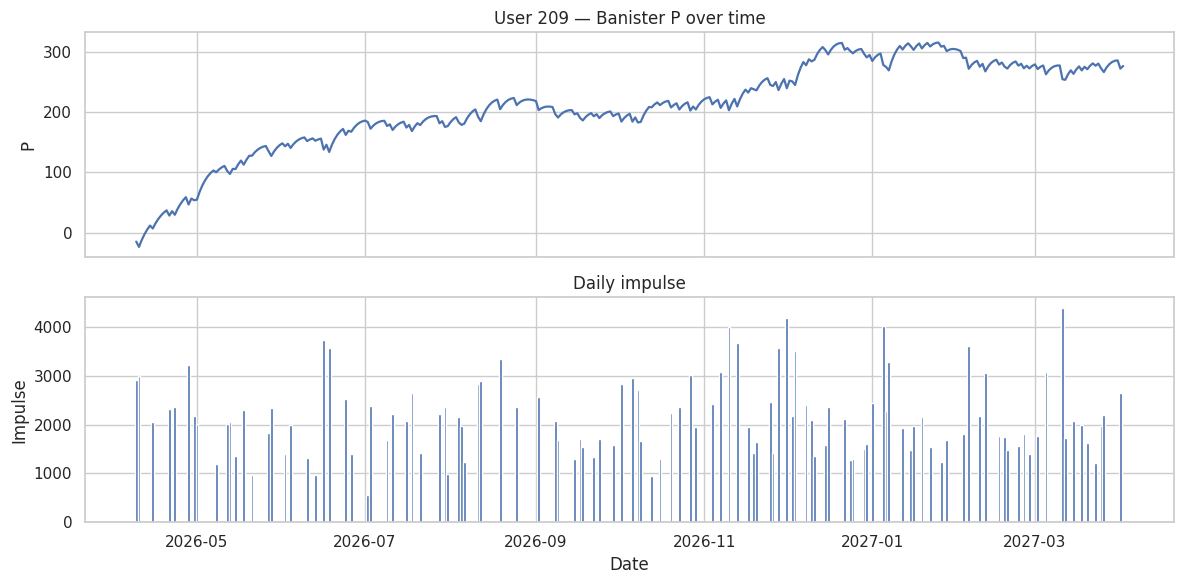

In [555]:
sub_ban = ban[ban["userid"] == uid].sort_values("date").copy()

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax[0].plot(sub_ban["date"], sub_ban["P"], linewidth=1.6)
ax[0].set_title(f"User {uid} — Banister P over time")
ax[0].set_ylabel("P")

ax[1].bar(sub_ban["date"], sub_ban["impulse"], width=1.0)
ax[1].set_title("Daily impulse")
ax[1].set_ylabel("Impulse")
ax[1].set_xlabel("Date")

plt.tight_layout()
plt.show()


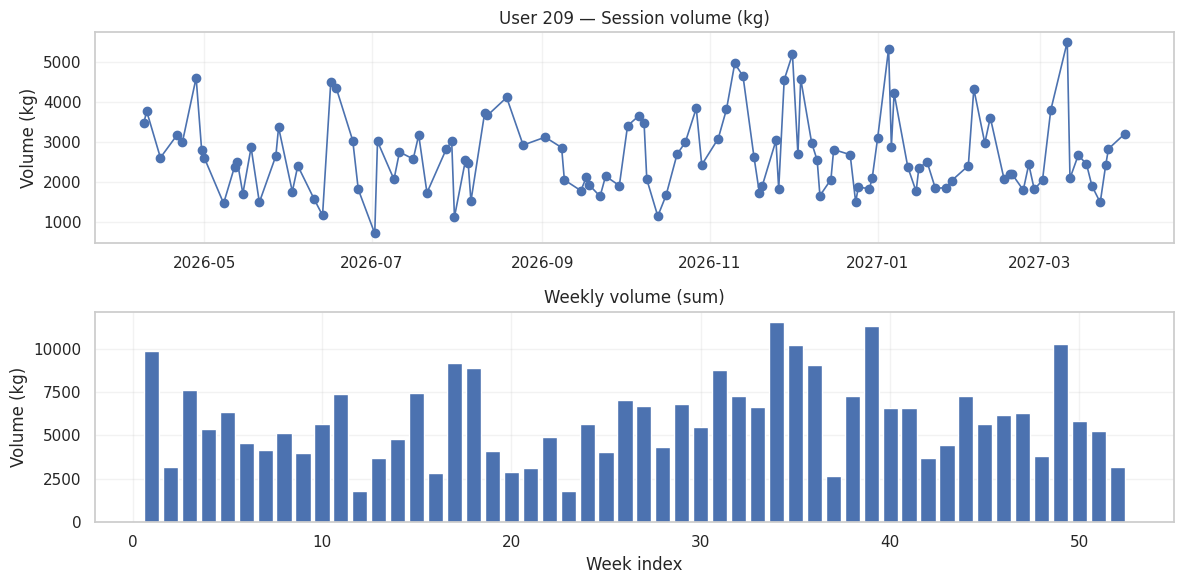

In [556]:
sub_sets = sets[sets["userid"] == uid].copy()

# volume set-level: load*reps (gestione NaN)
sub_sets["load0"] = sub_sets["load_done_kg"].fillna(0.0)
sub_sets["volume_kg"] = sub_sets["load0"] * sub_sets["reps_done"].astype(float)

# volume per sessione (workoutid)
vol_session = (sub_sets.groupby(["workoutid","date"], as_index=False)["volume_kg"]
               .sum()
               .sort_values("date"))

# volume per settimana (weekindex_user se presente, altrimenti calcolo ISO week)
if "weekindex_user" in sub_sets.columns:
    vol_week = sub_sets.groupby("weekindex_user", as_index=False)["volume_kg"].sum()
    x_week = vol_week["weekindex_user"]
else:
    vol_session["iso_week"] = vol_session["date"].dt.isocalendar().week.astype(int)
    vol_week = vol_session.groupby("iso_week", as_index=False)["volume_kg"].sum()
    x_week = vol_week["iso_week"]

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=False)

ax[0].plot(vol_session["date"], vol_session["volume_kg"], marker="o", linewidth=1.2)
ax[0].set_title(f"User {uid} — Session volume (kg)")
ax[0].set_ylabel("Volume (kg)")
ax[0].grid(True, alpha=0.25)

ax[1].bar(x_week, vol_week["volume_kg"])
ax[1].set_title("Weekly volume (sum)")
ax[1].set_ylabel("Volume (kg)")
ax[1].set_xlabel("Week index")
ax[1].grid(True, alpha=0.25)

plt.tight_layout()
plt.show()


In [557]:
sub_w = workouts[workouts["userid"] == uid].copy()

print("Sessions:", len(sub_w))
print("Done:", (sub_w["workoutstatus"] == "done").mean())
print("\nSession tags counts:")
print(sub_w["sessiontag"].value_counts(dropna=False).head(10))


Sessions: 136
Done: 0.8455882352941176

Session tags counts:
sessiontag
Legs    46
Push    45
Pull    45
Name: count, dtype: int64


In [558]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("data_synth_setlevel")  # cambia se serve

workouts = pd.read_csv(DATA_DIR / "workouts.csv")

# conteggi e percentuali
counts = workouts["workoutstatus"].value_counts(dropna=False)
pct = workouts["workoutstatus"].value_counts(dropna=False, normalize=True)

print(pd.concat([counts, pct], axis=1, keys=["count", "pct"]).round(4))

sessions = pd.read_csv(DATA_DIR / "sessions.csv")

# workoutid presenti in sessions ma non in workouts
missing_wid = set(sessions["workoutid"]) - set(workouts["workoutid"])
print("workoutid in sessions but not in workouts:", len(missing_wid))

# join per vedere lo status associato alle session
s_join = sessions.merge(workouts[["workoutid","workoutstatus","userid","date"]],
                        on="workoutid", how="left", validate="m:1")

print(s_join["workoutstatus"].value_counts(dropna=False, normalize=True).round(4))

n_workouts = len(workouts)
n_sessions = len(sessions)

print("workouts:", n_workouts)
print("sessions:", n_sessions)
print("sessions/workouts:", n_sessions / n_workouts)


               count     pct
workoutstatus               
done           47411  0.9023
skipped         5133  0.0977
workoutid in sessions but not in workouts: 0
workoutstatus
done    1.0
Name: proportion, dtype: float64
workouts: 52544
sessions: 47411
sessions/workouts: 0.9023104445797807




---


Serie di celle pronte (Pandas + Seaborn/Matplotlib) per avere un “cruscotto” rapido della distribuzione dei parametri e di alcune metriche derivate (skip-rate, volume, RPE, ecc.).

**CELL A — Import + load CSV**

In [559]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="whitegrid")

DATA_DIR = OUTDIR if "OUTDIR" in globals() else Path("data_synth_setlevel")  # cambia se serve

df_users   = pd.read_csv(DATA_DIR / "users.csv")
df_workouts= pd.read_csv(DATA_DIR / "workouts.csv")
df_sets    = pd.read_csv(DATA_DIR / "workout_sets.csv")

# opzionali
ban_path = DATA_DIR / "banisterdaily.csv"
df_ban = pd.read_csv(ban_path) if ban_path.exists() else None

for df in [df_users, df_workouts, df_sets]:
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")


**CELL B — Metriche per utente (sunto “alto livello”)**

In [560]:
# skip-rate per utente
w = df_workouts.copy()
w["is_skipped"] = (w["workoutstatus"] == "skipped").astype(int)
w["is_done"] = (w["workoutstatus"] == "done").astype(int)

per_user_workouts = (w.groupby("userid", as_index=False)
                     .agg(workouts_total=("workoutstatus","size"),
                          workouts_done=("is_done","sum"),
                          workouts_skipped=("is_skipped","sum"),
                          skip_rate=("is_skipped","mean")))

# volume per utente (da set-level): volume = load_done_kg * reps_done (NaN load -> 0)
s = df_sets.copy()
s["load0"] = s["load_done_kg"].fillna(0.0)
s["volume_kg"] = s["load0"] * s["reps_done"].astype(float)

per_user_volume = (s.groupby("userid", as_index=False)
                   .agg(sets_total=("set_id","count"),
                        volume_total_kg=("volume_kg","sum"),
                        volume_mean_set_kg=("volume_kg","mean"),
                        rpe_mean=("rpe_done","mean"),
                        rpe_std=("rpe_done","std")))

# merge con user params
label_col = "experience_label" if "experience_label" in df_users.columns else (
            "experiencedeclared" if "experiencedeclared" in df_users.columns else None)

keep_user_cols = ["userid"] + ([label_col] if label_col else [])
df_summary = (df_users[keep_user_cols]
              .merge(per_user_workouts, on="userid", how="left")
              .merge(per_user_volume, on="userid", how="left"))

df_summary.head()


,userid,experience_label,workouts_total,workouts_done,workouts_skipped,skip_rate,sets_total,volume_total_kg,volume_mean_set_kg,rpe_mean,rpe_std
0,1,Beginner,259,226,33,0.127413,2168,611816.00,282.202952,7.293201,0.668447
1,2,Intermediate,324,297,27,0.083333,2146,1054190.25,491.234972,8.426101,0.716915
2,3,Beginner,45,38,7,0.155556,418,119178.50,285.116029,8.154501,0.726568
3,4,Intermediate,149,128,21,0.140940,1262,597370.00,473.351823,8.205408,0.714761
4,5,Beginner,228,199,29,0.127193,1914,581020.75,303.563610,8.449629,0.740175


**CELL C — Distribuzioni parametri “puri” (users.csv)**

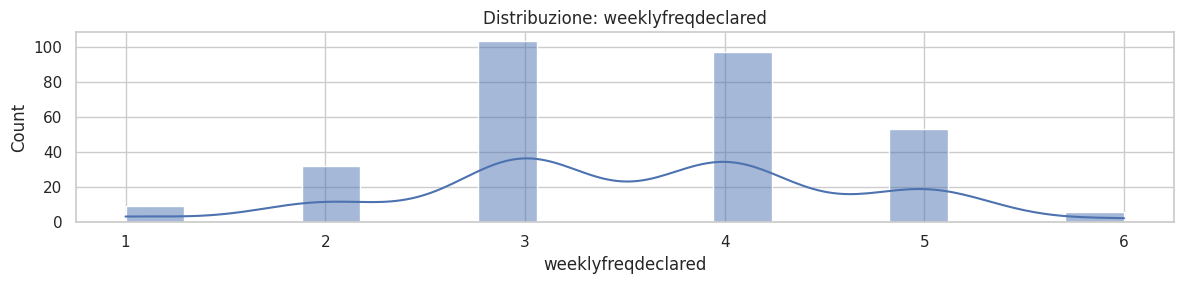

In [561]:
# scegli parametri numerici da plottare
candidate = [
    "weeklyfreqdeclared", "Aadherence", "fatiguesensitivity",
    "alphaprogression", "rpenoisesd", "rpereportbias"
]
param_cols = [c for c in candidate if c in df_users.columns]

n = len(param_cols)
fig, axes = plt.subplots(n, 1, figsize=(12, 3*n))
if n == 1:
    axes = [axes]

for ax, col in zip(axes, param_cols):
    sns.histplot(data=df_users, x=col, kde=True, ax=ax)
    ax.set_title(f"Distribuzione: {col}")

plt.tight_layout()
plt.show()


**CELL D — Confronto per livello (violin/box)**

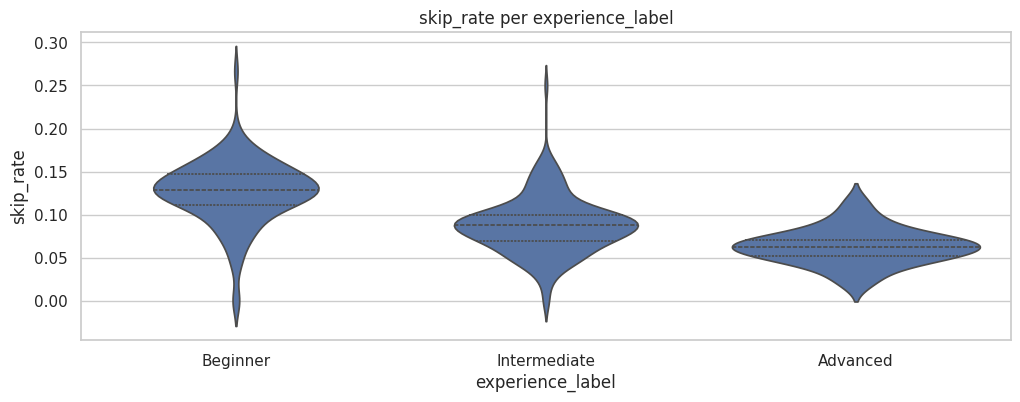

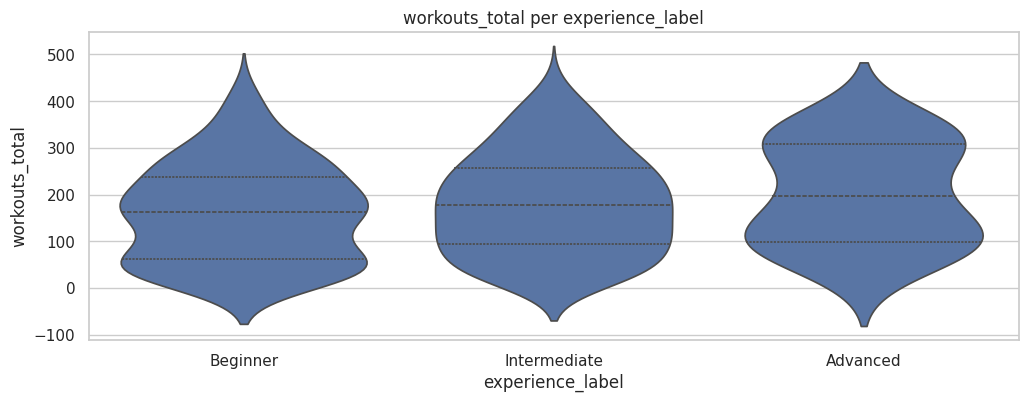

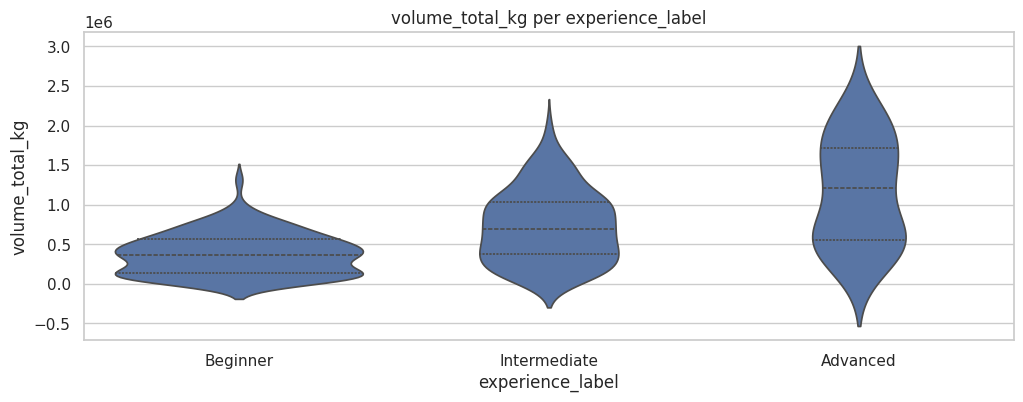

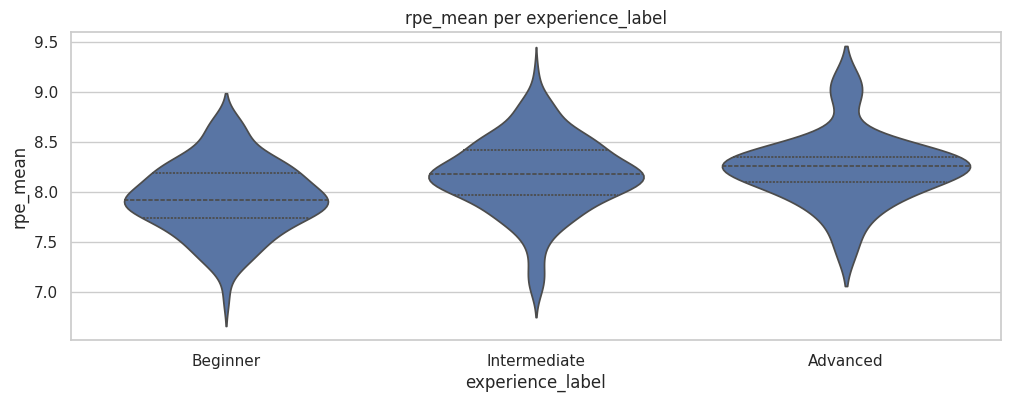

In [562]:
if label_col:
    # metriche “sintetiche” per confrontare i gruppi
    cols_to_compare = ["skip_rate", "workouts_total", "volume_total_kg", "rpe_mean"]
    cols_to_compare = [c for c in cols_to_compare if c in df_summary.columns]

    for col in cols_to_compare:
        plt.figure(figsize=(12, 4))
        sns.violinplot(data=df_summary, x=label_col, y=col, inner="quartile")
        plt.title(f"{col} per {label_col}")
        plt.show()


**CELL E — Correlazioni (heatmap)**

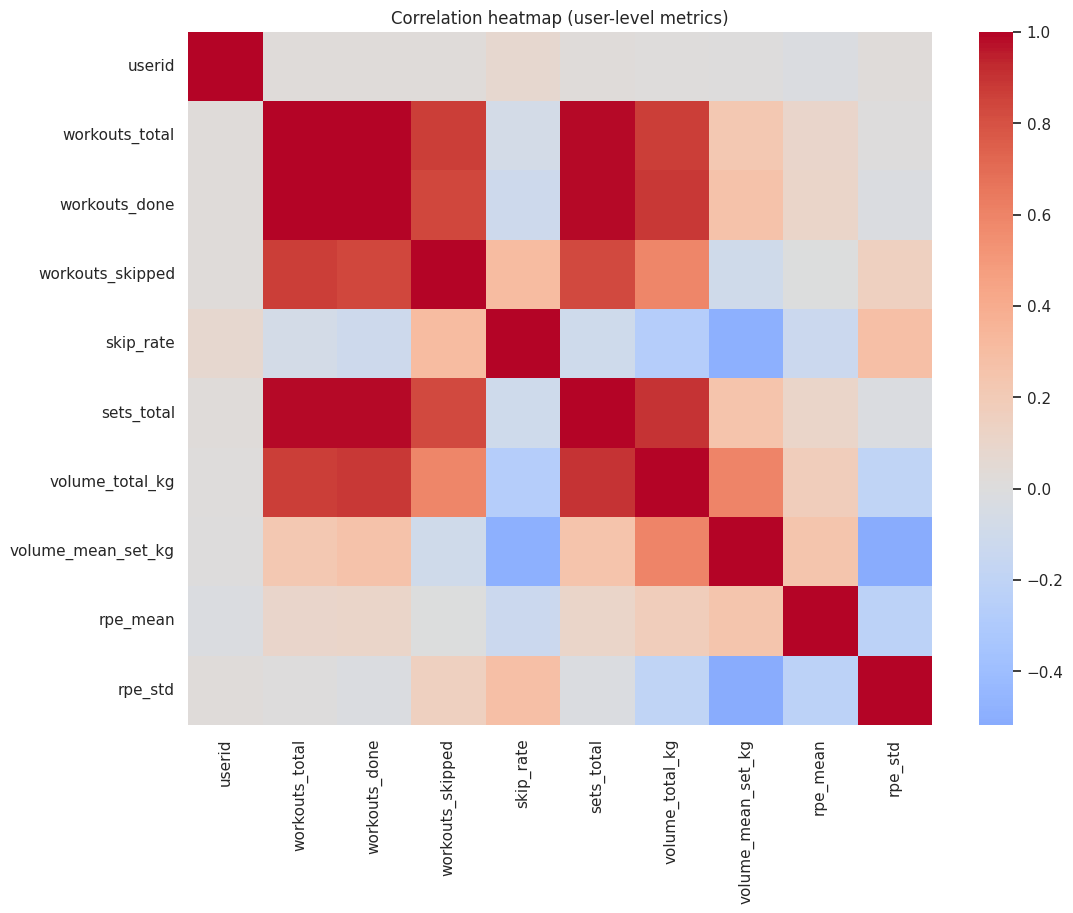

In [563]:
num = df_summary.select_dtypes(include=[np.number]).copy()
corr = num.corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation heatmap (user-level metrics)")
plt.show()


**CELL F — Banister: distribuzione di tau e P**

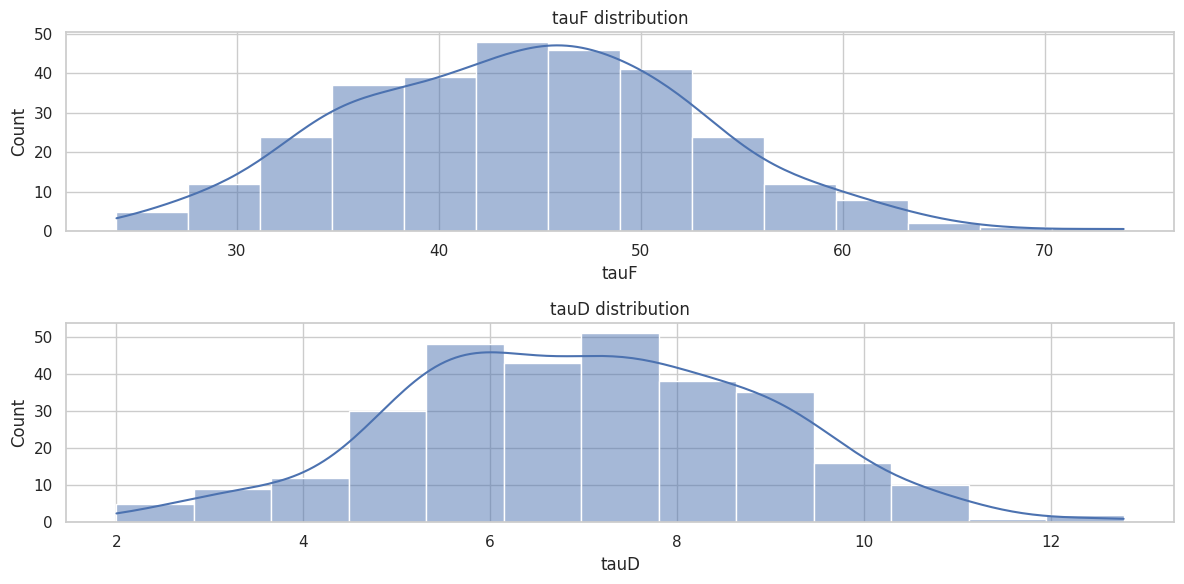

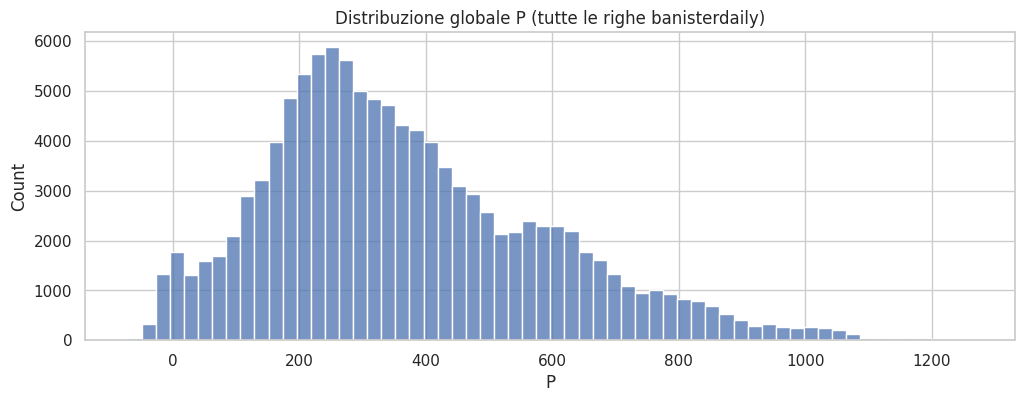

In [564]:
if df_ban is not None:
    # 1) distribuzione tau (un valore per utente: prendiamo la prima riga per uid)
    ban_meta = (df_ban.sort_values(["userid","date"])
                     .groupby("userid", as_index=False)
                     .first()[["userid","tauF","tauD","betaF","betaD"]])

    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    sns.histplot(ban_meta["tauF"], kde=True, ax=ax[0]); ax[0].set_title("tauF distribution")
    sns.histplot(ban_meta["tauD"], kde=True, ax=ax[1]); ax[1].set_title("tauD distribution")
    plt.tight_layout(); plt.show()

    # 2) P: distribuzione globale e per livello
    plt.figure(figsize=(12, 4))
    sns.histplot(data=df_ban, x="P", bins=60)
    plt.title("Distribuzione globale P (tutte le righe banisterdaily)")
    plt.show()


**CELL G - Load + pick random user (COMPLETA)**

In [565]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = OUTDIR if "OUTDIR" in globals() else Path("data_synth_setlevel")  # cambia se serve

ban = pd.read_csv(DATA_DIR / "banisterdaily.csv")
workouts = pd.read_csv(DATA_DIR / "workouts.csv")
sets = pd.read_csv(DATA_DIR / "workout_sets.csv")

ban["date"] = pd.to_datetime(ban["date"])
workouts["date"] = pd.to_datetime(workouts["date"])
sets["date"] = pd.to_datetime(sets["date"])

# Prendo un utente che abbia almeno N sessioni done (così il grafico è interessante)
N_MIN_DONE = 15
done_counts = (workouts[workouts["workoutstatus"] == "done"]
               .groupby("userid").size())

eligible = done_counts[done_counts >= N_MIN_DONE].index.values
if len(eligible) == 0:
    eligible = workouts["userid"].unique()

uid = int(np.random.choice(eligible, 1)[0])
uid


254

**CELL G.1 — EDA + Grafici utente (COMPLETA)**

USERID: 254
Periodo banister: 2026-01-02 -> 2026-07-15  (righe=195)
Workout DONE: 75
Set rows: 685

Banister summary (P, F, D, impulse):
             P          F          D   impulse
count  194.000    194.000    194.000   194.000
mean   247.864  38678.545   9261.406  1223.886
std    100.930  10991.851   2155.032  1776.138
min    -20.532   3415.566   3063.300     0.000
25%    228.615  36006.495   7829.569     0.000
50%    290.286  43099.523   9142.733     0.000
75%    317.969  45885.921  10639.547  2495.569
max    345.286  50365.661  17143.842  8595.963

Daily training summary:
         sets  reps_total  load_mean  load_max  volume_total  rpe_mean
count  75.000      75.000     75.000    75.000        75.000    75.000
mean    9.133      79.627     54.904    73.947      4124.760     7.885
std     3.718      31.641      7.004    14.649      1784.888     0.293
min     4.000      38.000     42.000    47.750      1697.500     6.938
25%     7.000      57.000     48.541    56.750      2905.875

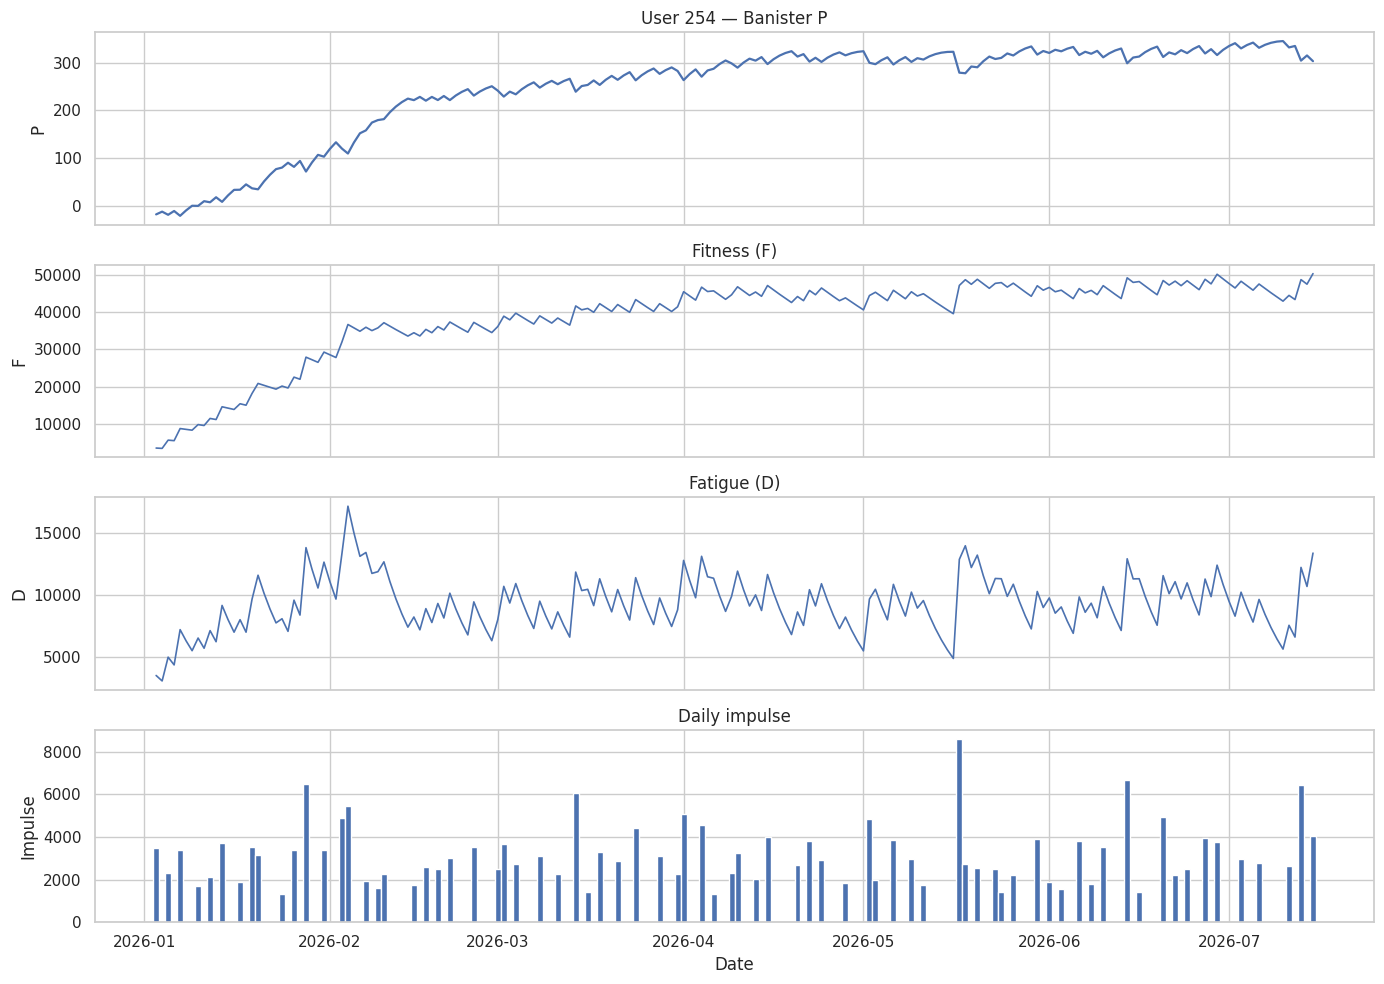

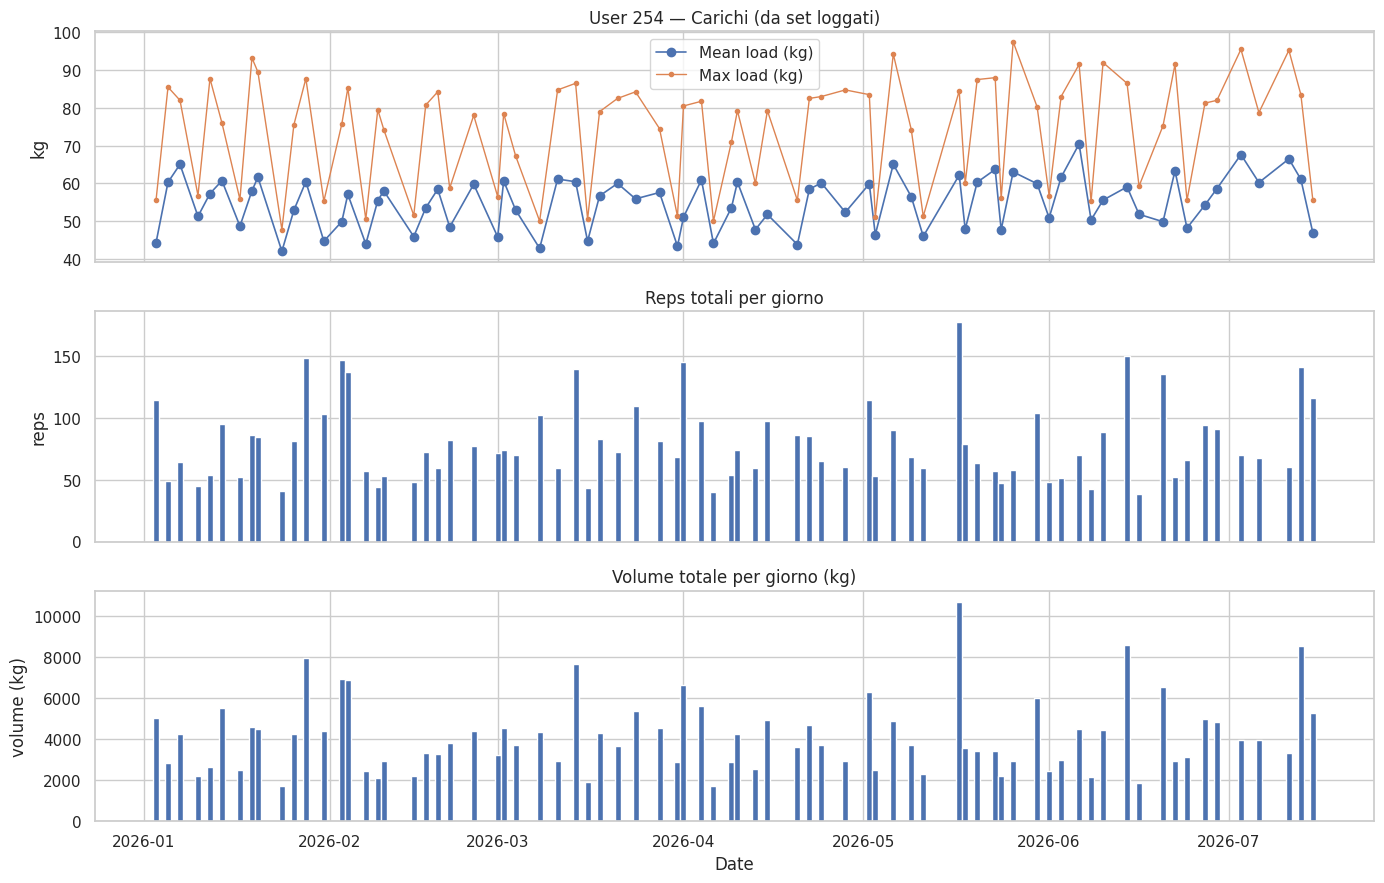

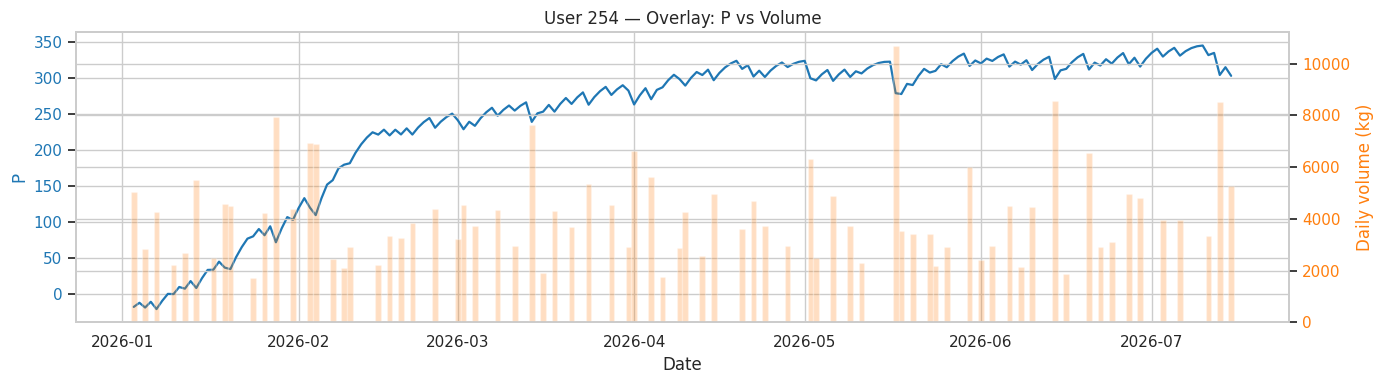

In [566]:
# --- subset dati utente ---
ban_u = ban[ban["userid"] == uid].sort_values("date").copy()
work_u = workouts[(workouts["userid"] == uid) & (workouts["workoutstatus"] == "done")].sort_values("date").copy()
sets_u = sets[sets["userid"] == uid].sort_values("date").copy()

# --- feature set-level derivate ---
sets_u["load0"] = sets_u["load_done_kg"].fillna(0.0)
sets_u["volume_kg"] = sets_u["load0"] * sets_u["reps_done"].astype(float)

# aggregazioni per giorno
daily_sets = (sets_u.groupby("date", as_index=False)
              .agg(sets=("set_id", "count") if "set_id" in sets_u.columns else ("reps_done","size"),
                   reps_total=("reps_done", "sum"),
                   load_mean=("load_done_kg", "mean"),
                   load_max=("load_done_kg", "max"),
                   volume_total=("volume_kg", "sum"),
                   rpe_mean=("rpe_done", "mean")))

# restringo il banister al periodo effettivo dove c'è attività (se preferisci)
if len(daily_sets) > 0:
    d0, d1 = daily_sets["date"].min(), daily_sets["date"].max()
    ban_u_plot = ban_u[(ban_u["date"] >= d0) & (ban_u["date"] <= d1)].copy()
else:
    ban_u_plot = ban_u.copy()

# --- EDA stampata (rapida) ---
print(f"USERID: {uid}")
print(f"Periodo banister: {ban_u['date'].min().date()} -> {ban_u['date'].max().date()}  (righe={len(ban_u)})")
print(f"Workout DONE: {len(work_u)}")
print(f"Set rows: {len(sets_u)}")
print("\nBanister summary (P, F, D, impulse):")
print(ban_u_plot[["P","F","D","impulse"]].describe().round(3))

print("\nDaily training summary:")
if len(daily_sets) > 0:
    print(daily_sets[["sets","reps_total","load_mean","load_max","volume_total","rpe_mean"]].describe().round(3))
else:
    print("Nessun set trovato per questo utente.")

# --- GRAFICO 1: Banister (P, F, D) + impulse ---
fig, ax = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

ax[0].plot(ban_u_plot["date"], ban_u_plot["P"], linewidth=1.6)
ax[0].set_title(f"User {uid} — Banister P")
ax[0].set_ylabel("P")

ax[1].plot(ban_u_plot["date"], ban_u_plot["F"], linewidth=1.2)
ax[1].set_title("Fitness (F)")
ax[1].set_ylabel("F")

ax[2].plot(ban_u_plot["date"], ban_u_plot["D"], linewidth=1.2)
ax[2].set_title("Fatigue (D)")
ax[2].set_ylabel("D")

ax[3].bar(ban_u_plot["date"], ban_u_plot["impulse"], width=1.0)
ax[3].set_title("Daily impulse")
ax[3].set_ylabel("Impulse")
ax[3].set_xlabel("Date")

plt.tight_layout()
plt.show()

# --- GRAFICO 2: Allenamenti nel tempo (carico, reps, volume) ---
# Nota: "carico" qui è load_mean e load_max per giorno (dai set loggati)
fig, ax = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

if len(daily_sets) > 0:
    ax[0].plot(daily_sets["date"], daily_sets["load_mean"], marker="o", linewidth=1.2, label="Mean load (kg)")
    ax[0].plot(daily_sets["date"], daily_sets["load_max"], marker=".", linewidth=1.0, label="Max load (kg)")
    ax[0].set_title(f"User {uid} — Carichi (da set loggati)")
    ax[0].set_ylabel("kg")
    ax[0].legend()

    ax[1].bar(daily_sets["date"], daily_sets["reps_total"], width=1.0)
    ax[1].set_title("Reps totali per giorno")
    ax[1].set_ylabel("reps")

    ax[2].bar(daily_sets["date"], daily_sets["volume_total"], width=1.0)
    ax[2].set_title("Volume totale per giorno (kg)")
    ax[2].set_ylabel("volume (kg)")
    ax[2].set_xlabel("Date")
else:
    ax[0].text(0.5, 0.5, "No daily sets to plot", ha="center", va="center")
    ax[1].axis("off")
    ax[2].axis("off")

plt.tight_layout()
plt.show()

# --- (opzionale) overlay: volume vs P (stesso grafico, due assi) ---
if len(daily_sets) > 0 and len(ban_u_plot) > 0:
    merged = pd.merge(
        ban_u_plot[["date","P"]],
        daily_sets[["date","volume_total"]],
        on="date", how="left"
    ).fillna({"volume_total": 0.0})

    fig, ax1 = plt.subplots(figsize=(14, 4))
    ax1.plot(merged["date"], merged["P"], color="tab:blue", linewidth=1.6)
    ax1.set_ylabel("P", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.bar(merged["date"], merged["volume_total"], alpha=0.25, color="tab:orange", width=1.0)
    ax2.set_ylabel("Daily volume (kg)", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    ax1.set_title(f"User {uid} — Overlay: P vs Volume")
    ax1.set_xlabel("Date")
    plt.tight_layout()
    plt.show()


**VALIDAZIONE CARICHI**

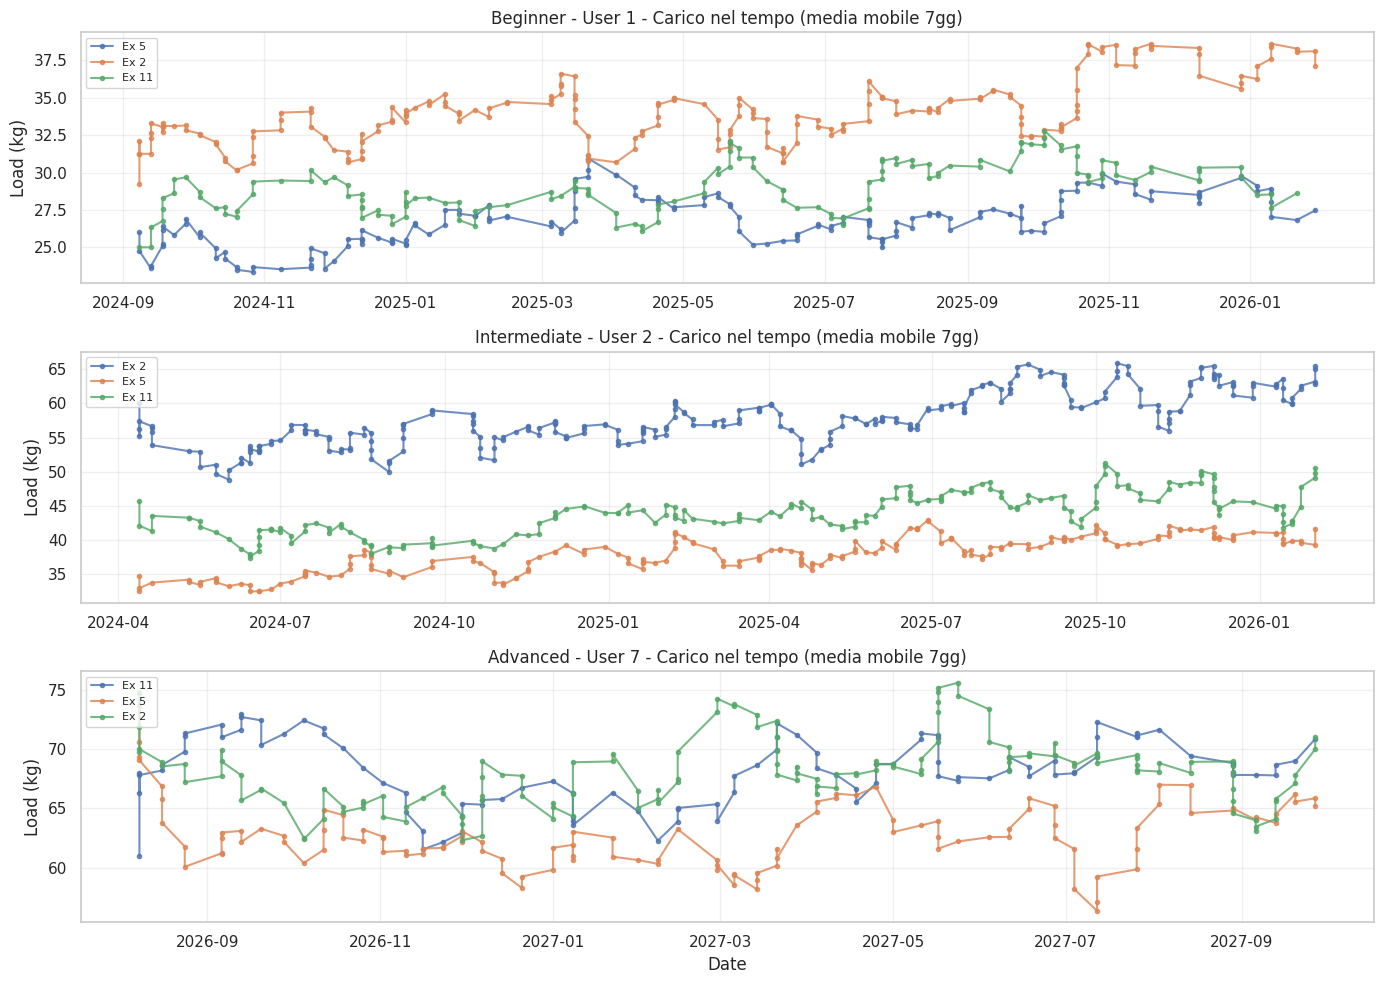

In [567]:
# === VALIDAZIONE CARICHI: 3 utenti (1 per livello) ===
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sets = pd.read_csv(OUTDIR / "workout_sets.csv")
users = pd.read_csv(OUTDIR / "users.csv")
sets = sets.merge(users[["userid", "experience_label"]], on="userid")
sets["date"] = pd.to_datetime(sets["date"])

# Scegli 1 utente per livello con almeno 40 sessioni done
def pick_user_by_level(level, min_sessions=40):
    candidates = users[users["experience_label"] == level]["userid"].values
    for uid in candidates:
        n = len(sets[(sets["userid"] == uid) & (sets["load_done_kg"].notna())])
        if n >= min_sessions:
            return uid
    return candidates[0] if len(candidates) else None

uids = {
    "Beginner": pick_user_by_level("Beginner"),
    "Intermediate": pick_user_by_level("Intermediate"),
    "Advanced": pick_user_by_level("Advanced"),
}

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=False)

for ax, (level, uid) in zip(axes, uids.items()):
    if uid is None:
        ax.text(0.5, 0.5, f"No {level} user found", ha="center")
        continue

    sub = sets[(sets["userid"] == uid) & (sets["load_done_kg"].notna())].copy()
    sub = sub.sort_values("date")

    # Per ogni esercizio: grafico carico nel tempo
    for exid in sub["exerciseid"].unique()[:3]:  # max 3 esercizi per leggibilità
        ex_data = sub[sub["exerciseid"] == exid].copy()
        if len(ex_data) < 5:
            continue

        # Media mobile 7-giorni per smooth
        ex_data["load_smooth"] = ex_data["load_done_kg"].rolling(window=7, min_periods=1).mean()

        ax.plot(ex_data["date"], ex_data["load_smooth"],
                marker="o", markersize=3, linewidth=1.5, alpha=0.8,
                label=f"Ex {exid}")

    ax.set_title(f"{level} - User {uid} - Carico nel tempo (media mobile 7gg)")
    ax.set_ylabel("Load (kg)")
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()


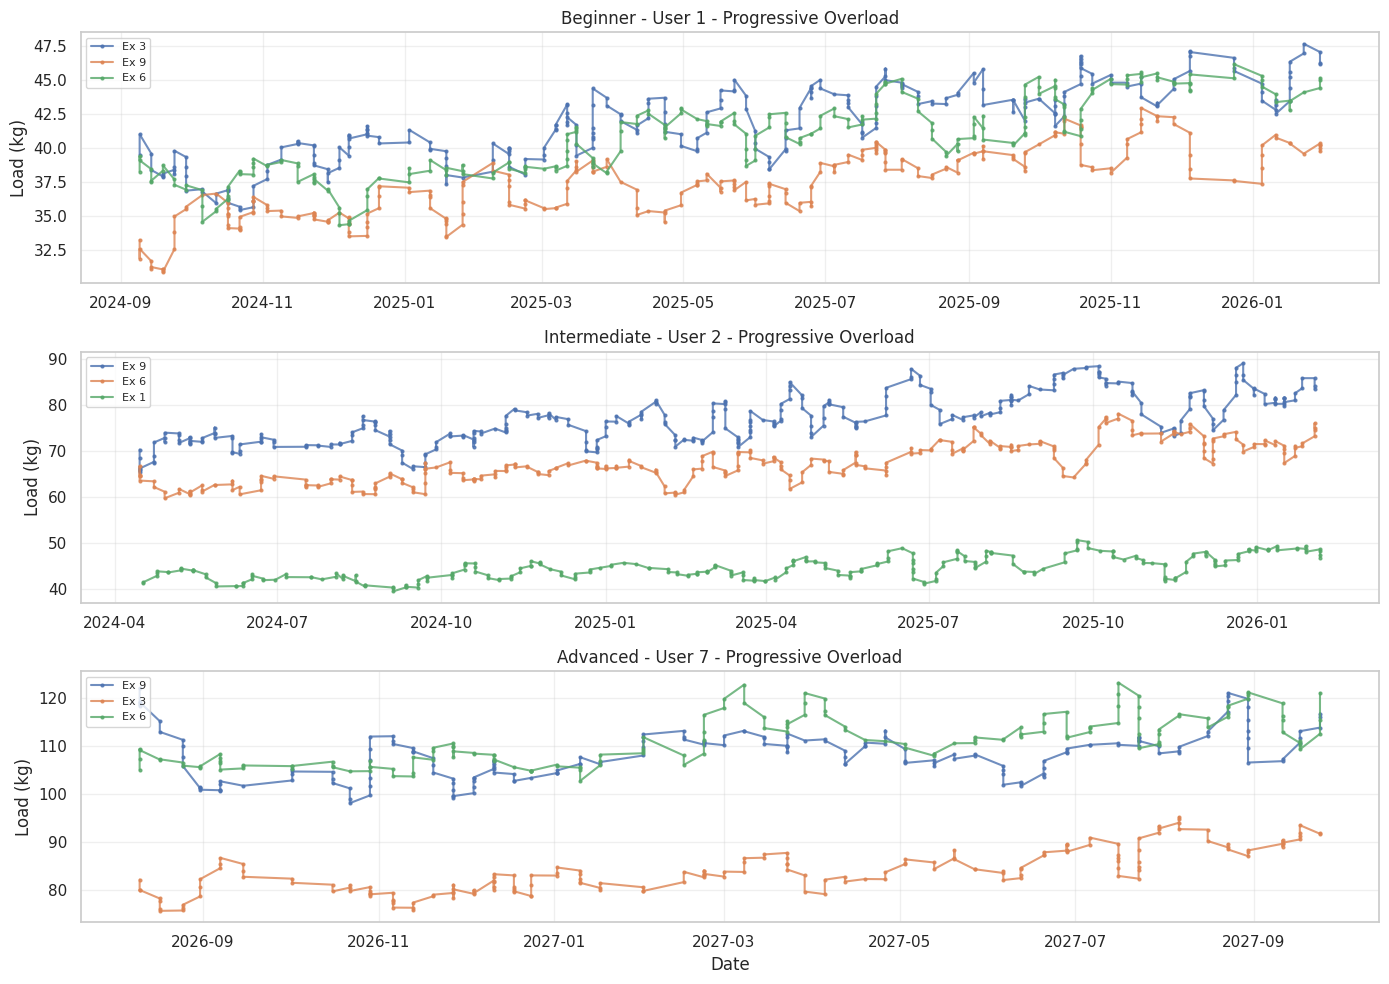


=== PROGRESSIVE OVERLOAD per livello ===
                  slope_kg_per_week  pct_gain
experience_label                             
Advanced                      0.070     6.355
Beginner                      0.071    12.037
Intermediate                  0.101    11.118

=== Target attesi ===
Beginner: +0.8-1.5 kg/week, gain ~15-25%
Intermediate: +0.3-0.8 kg/week, gain ~8-15%
Advanced: +0.1-0.4 kg/week, gain ~3-8%


In [568]:
# === VALIDAZIONE PROGRESSIVE OVERLOAD ===
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

sets = pd.read_csv(OUTDIR / "workout_sets.csv")
users = pd.read_csv(OUTDIR / "users.csv")
sets = sets.merge(users[["userid", "experience_label"]], on="userid")
sets["date"] = pd.to_datetime(sets["date"])

# Funzione helper: scegli 1 utente per livello
def pick_user(level, min_sessions=50):
    candidates = users[users["experience_label"] == level]["userid"].values
    for uid in candidates:
        n = len(sets[(sets["userid"] == uid) & (sets["load_done_kg"].notna())])
        if n >= min_sessions:
            return uid
    return candidates[0] if len(candidates) else None

# 1 utente per livello
uids = {
    "Beginner": pick_user("Beginner"),
    "Intermediate": pick_user("Intermediate"),
    "Advanced": pick_user("Advanced"),
}

# Plot carichi nel tempo
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for ax, (level, uid) in zip(axes, uids.items()):
    if uid is None:
        continue

    sub = sets[(sets["userid"] == uid) & (sets["load_done_kg"].notna())].sort_values("date")

    # Prendi max 3 esercizi più allenati
    top_ex = sub["exerciseid"].value_counts().head(3).index

    for exid in top_ex:
        ex_data = sub[sub["exerciseid"] == exid].copy()
        if len(ex_data) < 10:
            continue

        # Smooth con media mobile 7 set
        ex_data["load_smooth"] = ex_data["load_done_kg"].rolling(window=7, min_periods=1).mean()

        ax.plot(ex_data["date"], ex_data["load_smooth"],
                marker="o", markersize=2, linewidth=1.5, alpha=0.8, label=f"Ex {exid}")

    ax.set_title(f"{level} - User {uid} - Progressive Overload")
    ax.set_ylabel("Load (kg)")
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

# Metriche quantitative: trend per livello
results = []
for (uid, exid), grp in sets.groupby(["userid", "exerciseid"]):
    grp = grp[grp["load_done_kg"].notna()].sort_values("date")
    if len(grp) < 15:
        continue

    grp["day_num"] = (grp["date"] - grp["date"].min()).dt.days
    slope, _, r_val, _, _ = linregress(grp["day_num"], grp["load_done_kg"])

    label = grp["experience_label"].iloc[0]
    results.append({
        "experience_label": label,
        "slope_kg_per_day": slope,
        "slope_kg_per_week": slope * 7,
        "pct_gain": ((grp["load_done_kg"].iloc[-5:].mean() / grp["load_done_kg"].iloc[:5].mean()) - 1) * 100
    })

df_trends = pd.DataFrame(results)

print("\n=== PROGRESSIVE OVERLOAD per livello ===")
print(df_trends.groupby("experience_label")[["slope_kg_per_week", "pct_gain"]].mean().round(3))

print("\n=== Target attesi ===")
print("Beginner: +0.8-1.5 kg/week, gain ~15-25%")
print("Intermediate: +0.3-0.8 kg/week, gain ~8-15%")
print("Advanced: +0.1-0.4 kg/week, gain ~3-8%")
